In [150]:
# 3. 能量响应分析：发射能量 vs 沉积能量
import matplotlib.pyplot as plt


# 检查 ROOT 文件中的所有分支
import uproot
import os

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import importlib
import data_loader

importlib.reload(data_loader)
from data_loader import load_and_process_data

from matplotlib.colors import LogNorm

## DataLoading

In [151]:
# 检查 ROOT 文件中的所有分支
import uproot
import os

root_file = "data/res2.root"
file = uproot.open(root_file)
tree = file["CsI"]

print("ROOT 文件中的所有分支:")
print("=" * 60)
for branch_name in tree.keys():
    branch = tree[branch_name]
    print(f"{branch_name:30s} {branch.typename}")
print("=" * 60)

ROOT 文件中的所有分支:
EventID                        int32_t
TotalEdep                      double
HitCount                       int32_t
CrystalID                      std::vector<int32_t>
CrystalEdep                    std::vector<double>
CrystalTime                    std::vector<double>
CrystalPosX                    std::vector<double>
CrystalPosY                    std::vector<double>
CrystalPosZ                    std::vector<double>
CrystalPDG                     std::vector<int32_t>
CrystalTrackID                 std::vector<int32_t>
CrystalParentID                std::vector<int32_t>
CrystalDirX                    std::vector<double>
CrystalDirY                    std::vector<double>
CrystalDirZ                    std::vector<double>
CrystalKineticEnergy           std::vector<double>
CrystalProcessID               std::vector<int32_t>
CrystalTrackLength             std::vector<double>
PrimaryPDG                     std::vector<int32_t>
PrimaryEnergy                  std::vector<doub

In [152]:
# 删除旧的缓存文件，以便重新生成包含所有分支的数据（包括新增的 trackLength）
import os

cache_files = ["data/res2_hits.parquet", "data/res2_primaries.parquet"]
for cache_file in cache_files:
    if os.path.exists(cache_file):
        os.remove(cache_file)
        print(f"已删除旧缓存: {cache_file}")

In [158]:
# ================== 读取与预处理数据 ==================

from data_loader import load_and_process_data

# 配置路径
# root_file = "data/res2.root"
root_file = "data/res2_Cube10cm.root"
output_dir = "plots"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

try:
    # 一键加载并预处理 (会自动读取/生成 parquet 缓存)
    # 现在包含了新的 trackLength 字段
    data, df_hits, df_primaries, process_map, num_events = load_and_process_data(root_file, cache=False)

    print("\nDataFrame Preview (Hits):")
    print(df_hits.head())
    print(f"\n列名: {list(df_hits.columns)}")

    print("\nDataFrame Preview (Primaries):")
    print(df_primaries.head())

    # 为了兼容后面的绘图代码，将 DataFrame 列赋值给变量
    flat_edep = df_hits["edep"]
    flat_time = df_hits["time"]
    flat_posX = df_hits["posX"]
    flat_posY = df_hits["posY"]
    flat_pdg = df_hits["pdg"]
    flat_process = df_hits["processID"]
    flat_id = df_hits["crystalID"]
    flat_track_length = df_hits["trackLength"]  # 新增：Track Length 数据

except Exception as e:
    print(f"Error: {e}")
    import traceback

    traceback.print_exc()

[Info] Loaded 7 processes from 'data/res2_Cube10cm_ProcessIDMap.txt'
Opening ROOT file: data/res2_Cube10cm.root...
Successfully loaded 1000000 events from ROOT.
Converting to Pandas DataFrames...
Successfully loaded 1000000 events from ROOT.
Converting to Pandas DataFrames...
Processing Primary particles...
Processing Primary particles...

DataFrame Preview (Hits):
   EventID  hit_idx  crystalID      edep      time        posX        posY  \
0        0        0      40502  8.213367  0.000000   48.296882  149.597058   
1        0        1      50402  0.808631  0.292710  101.500000   91.409300   
2        1        0      70400  8.384543  0.000000  327.489299   46.232988   
3        1        1      70401  0.637455  0.108959  326.577500   59.701906   
4        2        0      70203  8.614892  0.000000  312.019068 -125.196441   

         posZ  pdg  parentID      dirX      dirY      dirZ  kineticEnergy  \
0  -21.023809  -11         0  0.310921  0.746763  0.587939       4.000000   
1    6.39

In [159]:
len(data["PrimaryPosY"][:, 1])

1000000

In [176]:
data

<Array [{EventID: 0, TotalEdep: ..., ...}, ...] type='1000000 * {EventID: i...'>

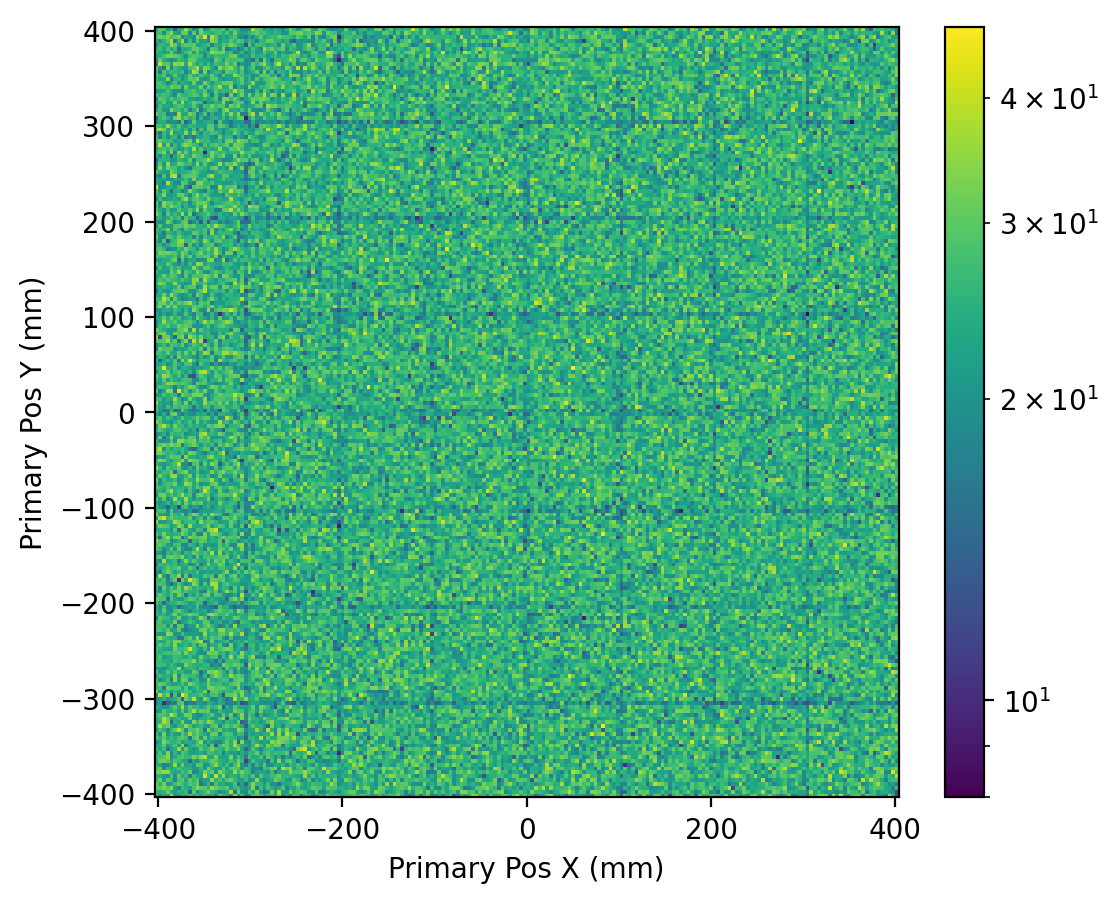

In [177]:
plt.figure(figsize=(6, 5))
plt.hist2d(data["PrimaryPosX"][:, 1].to_numpy(), data["PrimaryPosY"][:, 1].to_numpy(), bins=200, norm=LogNorm())
plt.xlabel("Primary Pos X (mm)")
plt.ylabel("Primary Pos Y (mm)")

plt.colorbar()
plt.show()

Text(0, 0.5, 'Primary Pos Z (mm)')

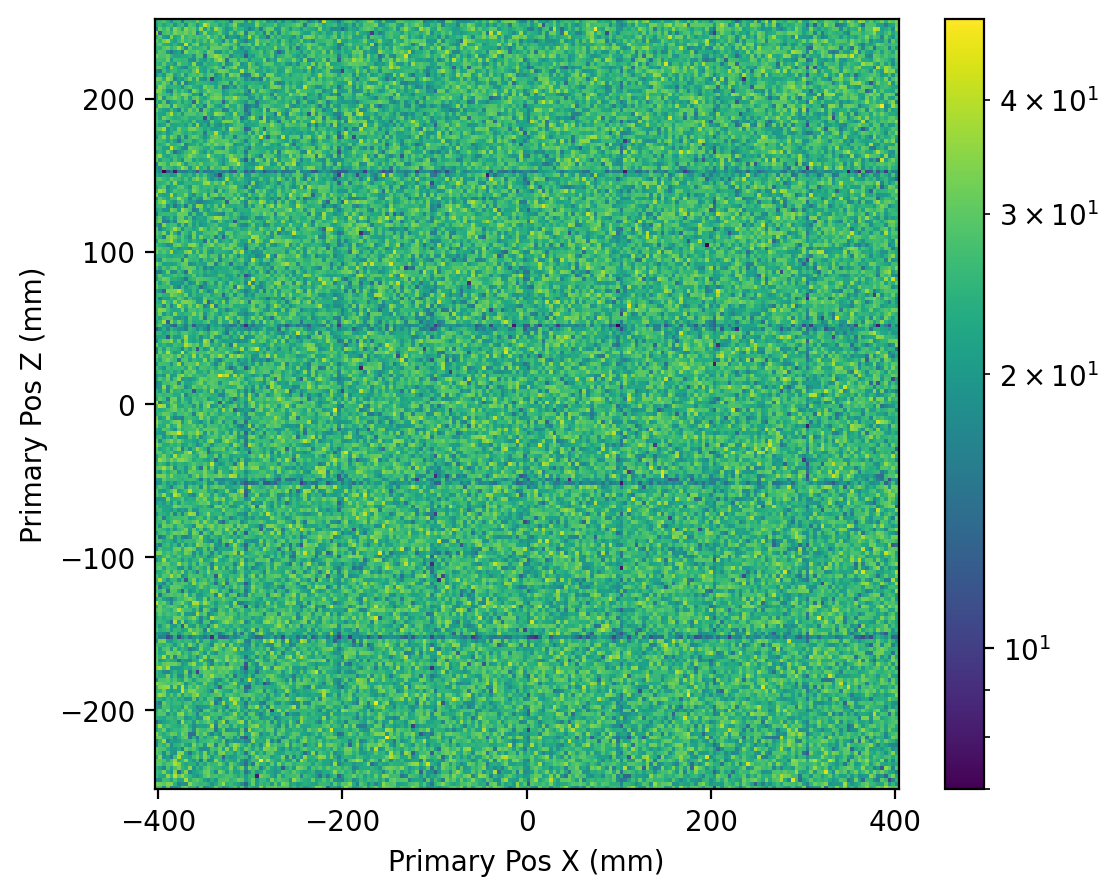

In [178]:
plt.figure(figsize=(6, 5))
plt.hist2d(data["PrimaryPosX"][:, 1].to_numpy(), data["PrimaryPosZ"][:, 1].to_numpy(), bins=200, norm=LogNorm())
plt.colorbar()
plt.xlabel("Primary Pos X (mm)")
plt.ylabel("Primary Pos Z (mm)")

# Process

In [162]:
# ================== 关联发射粒子与探测器 Hit ==================

# 1. 将发射粒子信息合并到 Hit 数据中
# 我们使用 EventID 作为键进行合并
# suffixes=('_hit', '_primary') 用于区分同名列 (如 pdg, posX 等)
df_merged = pd.merge(df_hits, df_primaries, on="EventID", suffixes=("_hit", "_primary"))

print("合并后的 DataFrame (前 5 行):")
# 选取一些关键列进行展示
cols_to_show = ["EventID", "edep", "pdg_hit", "parentID", "pdg_primary", "energy"]
print(df_merged[cols_to_show].head())

# 2. 区分 Hit 是由初级粒子直接产生，还是由次级粒子产生
# 在 Geant4 中，通常 ParentID = 0 表示该径迹是初级粒子
# 如果 parentID == 0，说明产生这个 Hit 的粒子就是发射的粒子本身
primary_hits = df_merged[df_merged["parentID"] == 0]
secondary_hits = df_merged[df_merged["parentID"] > 0]

print(f"\n统计信息:")
print(f"  总 Hits 数: {len(df_merged)}")
print(f"  初级粒子直接产生的 Hits: {len(primary_hits)} ({len(primary_hits) / len(df_merged):.1%})")
print(f"  次级粒子产生的 Hits: {len(secondary_hits)} ({len(secondary_hits) / len(df_merged):.1%})")

合并后的 DataFrame (前 5 行):
   EventID      edep  pdg_hit  parentID  pdg_primary    energy
0        0  8.213367      -11         0           11  4.510999
1        0  8.213367      -11         0          -11  4.510999
2        0  0.808631       22         2           11  4.510999
3        0  0.808631       22         2          -11  4.510999
4        1  8.384543      -11         0           11  4.510999

统计信息:
  总 Hits 数: 4379934
  初级粒子直接产生的 Hits: 2113560 (48.3%)
  次级粒子产生的 Hits: 2266374 (51.7%)


In [163]:
df_energy_corr

,EventID,total_edep,total_primary_energy
0,0,9.021998,9.021998
1,1,9.021643,9.021998
2,2,9.021998,9.021998
3,3,9.021998,9.021998
4,4,9.021998,9.021998
...,...,...,...
99995,99995,9.021998,9.021998
99996,99996,9.021998,9.021998
99997,99997,9.021998,9.021998
99998,99998,9.021998,9.021998


In [179]:
# 按 EventID 分组计算总沉积能量
event_edep = df_hits.groupby("EventID")["edep"].sum().reset_index()
event_edep.rename(columns={"edep": "total_edep"}, inplace=True)

# 合并发射能量信息
# 注意：一个事件可能有多个发射粒子，这里我们计算每个事件的总发射能量
event_primary = df_primaries.groupby("EventID")["energy"].sum().reset_index()
event_primary.rename(columns={"energy": "total_primary_energy"}, inplace=True)

# 合并两个统计结果
df_energy_corr = pd.merge(event_edep, event_primary, on="EventID")

In [180]:
df_hits

,EventID,hit_idx,crystalID,edep,time,posX,posY,posZ,pdg,parentID,dirX,dirY,dirZ,kineticEnergy,processID,trackLength,trackID,ix,iy,iz
0,0,0,40502,8.213367,0.000000,48.296882,149.597058,-21.023809,-11,0,0.310921,0.746763,0.587939,4.000000,0,81.073482,2,4,5,2
1,0,1,50402,0.808631,0.292710,101.500000,91.409300,6.392087,22,2,0.613230,-0.749588,0.249132,0.808631,1,37.990124,11,5,4,2
2,1,0,70400,8.384543,0.000000,327.489299,46.232988,-179.762706,-11,0,0.630698,0.713049,-0.306238,4.000000,0,46.918513,2,7,4,0
3,1,1,70401,0.637455,0.108959,326.577500,59.701906,-151.000000,22,1,-0.043989,0.397754,0.916437,0.637455,1,98.548418,278,7,4,1
4,2,0,70203,8.614892,0.000000,312.019068,-125.196441,108.663097,-11,0,0.997163,-0.060999,-0.044107,4.000000,0,47.732623,2,7,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189962,999997,0,40003,8.890588,0.000000,45.831135,-305.575878,101.493741,-11,0,-0.170842,-0.273519,0.946573,4.000000,0,100.509104,2,4,0,3
2189963,999997,1,40103,0.131410,0.063911,35.796714,-302.500000,93.372696,22,2,-0.655380,0.191161,-0.730708,0.510999,1,8.534326,128,4,1,3
2189964,999998,0,501,9.021998,0.000000,-376.572119,162.434934,-82.170910,-11,0,-0.818610,-0.468723,0.331927,4.000000,0,92.213442,2,0,5,1
2189965,999999,0,20201,8.536743,0.000000,-129.755236,-113.411826,-138.628249,-11,0,-0.108627,0.119447,-0.986880,4.000000,0,72.260478,2,2,2,1


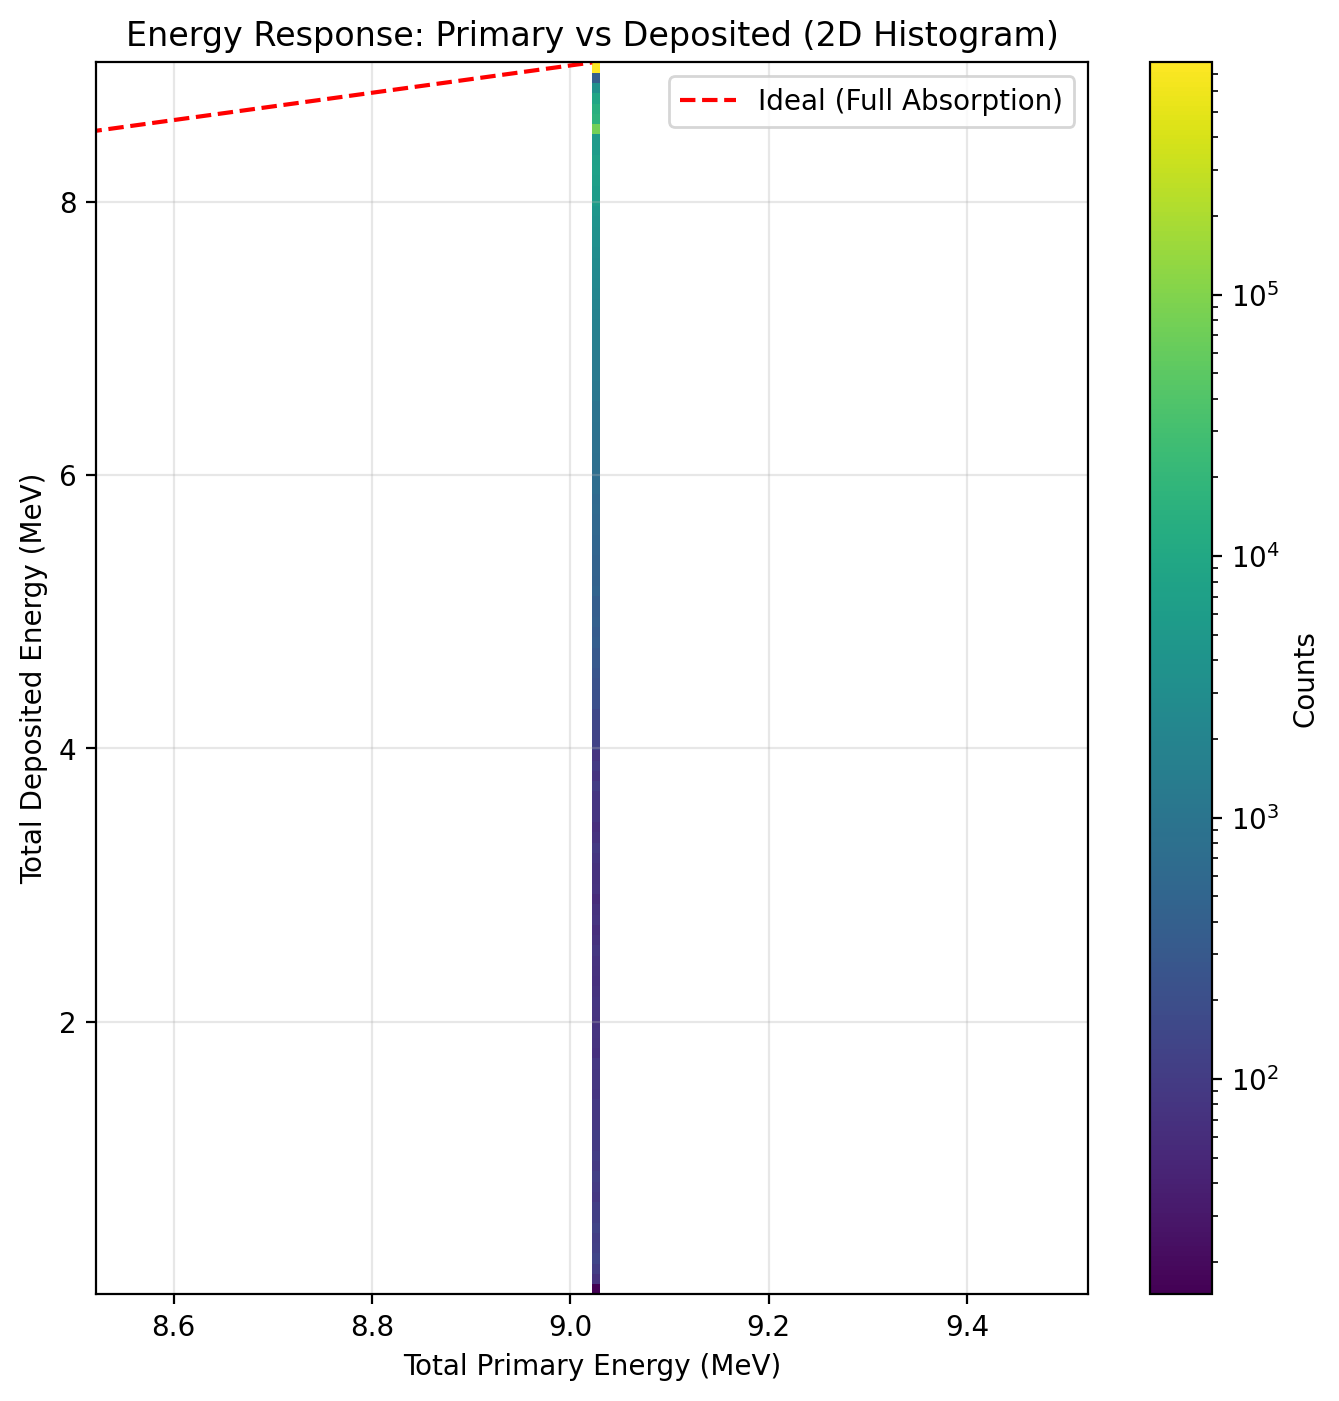

In [181]:
# 绘图 1: 能量响应二维直方图
plt.figure(figsize=(8, 8))
counts, xedges, yedges, image = plt.hist2d(
    df_energy_corr["total_primary_energy"],
    df_energy_corr["total_edep"],
    bins=(120, 120),
    norm=LogNorm(),
    cmap="viridis",
)
plt.colorbar(image, label="Counts")
# 绘制 y=x 参考线
max_e = max(df_energy_corr["total_primary_energy"].max(), df_energy_corr["total_edep"].max())
plt.plot([0, max_e], [0, max_e], "r--", label="Ideal (Full Absorption)")

plt.xlabel("Total Primary Energy (MeV)")
plt.ylabel("Total Deposited Energy (MeV)")
plt.title("Energy Response: Primary vs Deposited (2D Histogram)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [182]:
df_hits
event_id_counts = df_hits["EventID"].value_counts().sort_index().rename("hit_count").to_frame()
event_id_counts[event_id_counts["hit_count"] > 6]

,hit_count
EventID,
491,7
1819,7
2742,8
3830,7
4746,7
...,...
996468,7
997068,8
997180,7


In [183]:
df_hits[df_hits["EventID"] == 514]

,EventID,hit_idx,crystalID,edep,time,posX,posY,posZ,pdg,parentID,dirX,dirY,dirZ,kineticEnergy,processID,trackLength,trackID,ix,iy,iz
1111,514,0,103,8.510999,0.0,-398.707867,-236.220285,139.41232,-11,0,-0.13767,-0.766875,-0.626857,4.0,0,48.675899,2,0,1,3


In [184]:
np.sum(df_hits[df_hits["EventID"] == 514])

/home/wxy/anaconda3/envs/pyroot-kernel/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


EventID          514.000000
hit_idx            0.000000
crystalID        103.000000
edep               8.510999
time               0.000000
posX            -398.707867
posY            -236.220285
posZ             139.412320
pdg              -11.000000
parentID           0.000000
dirX              -0.137670
dirY              -0.766875
dirZ              -0.626857
kineticEnergy      4.000000
processID          0.000000
trackLength       48.675899
trackID            2.000000
ix                 0.000000
iy                 1.000000
iz                 3.000000
dtype: float64

###  击中数分布

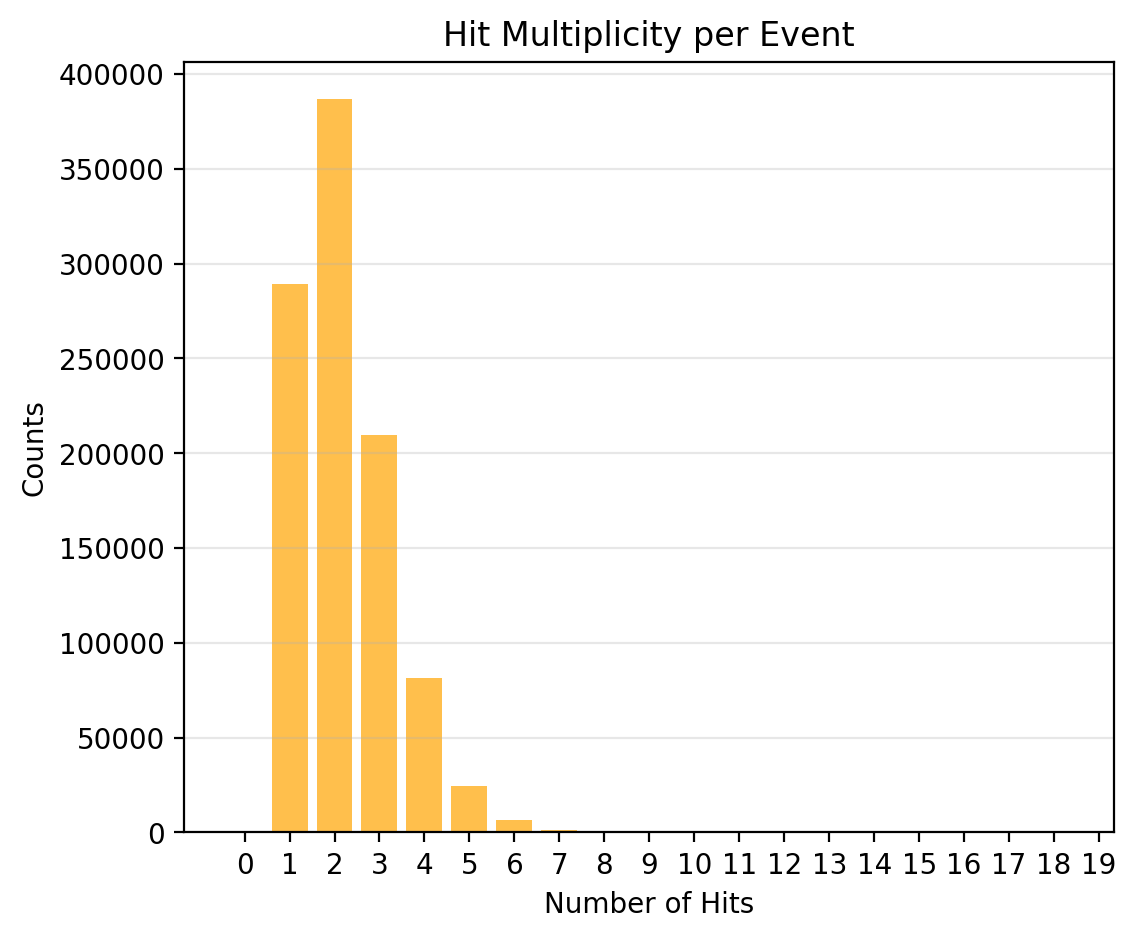

In [185]:
plt.figure(figsize=(6, 5))
plt.hist(data["HitCount"], bins=range(0, 20), align="left", rwidth=0.8, color="orange", alpha=0.7)
plt.xlabel("Number of Hits")
plt.ylabel("Counts")
plt.title("Hit Multiplicity per Event")
plt.xticks(range(0, 20))
plt.grid(True, axis="y", alpha=0.3)
plt.show()


In [186]:
data

<Array [{EventID: 0, TotalEdep: ..., ...}, ...] type='1000000 * {EventID: i...'>

NameError: name 'CsI' is not defined

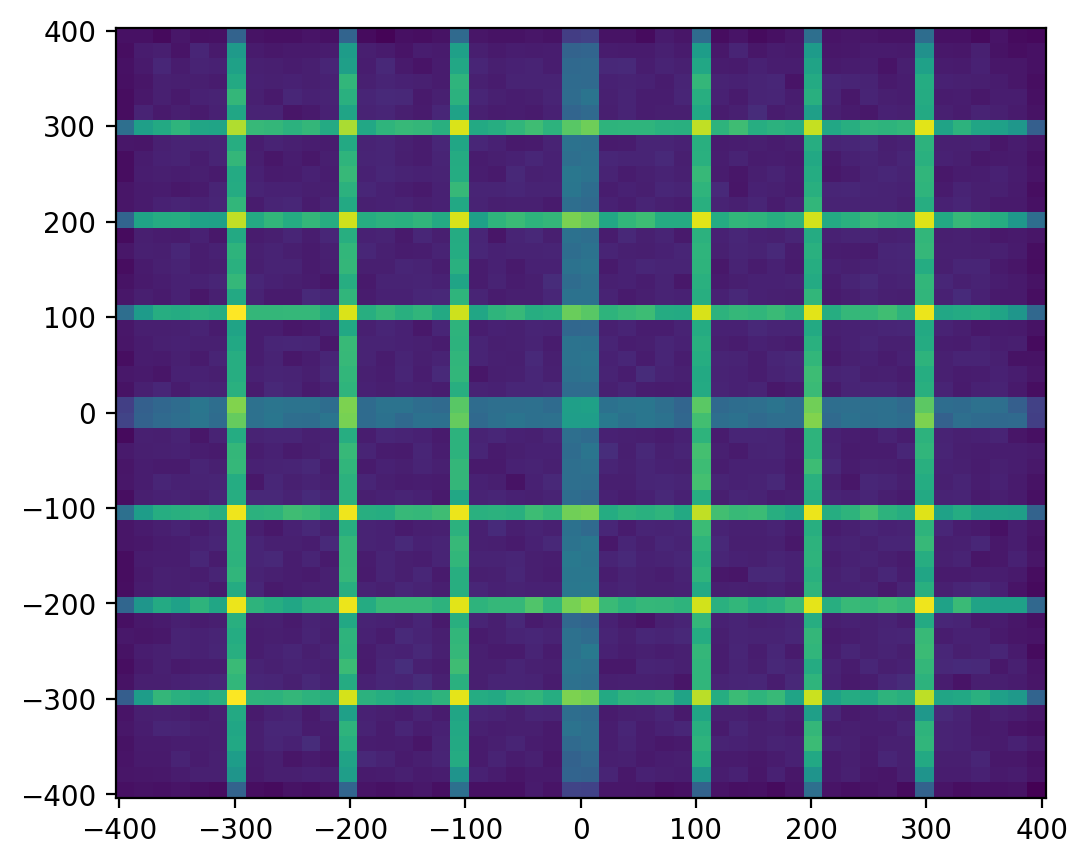

In [187]:
# 3. 击中位置分布 (Hit Positions X-Y)
plt.figure(figsize=(6, 5))
plt.hist2d(flat_posX, flat_posY, bins=50, cmap="viridis", cmin=1)
/CsI/detector/gapMaterial OpticalGrease
plt.colorbar(label="Counts")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.title("Hit Positions (X-Y)")
plt.axis("equal")
plt.show()


### 物理过程分布

In [191]:
pip install madgraph

ERROR: Could not find a version that satisfies the requirement madgraph (from versions: none)
ERROR: No matching distribution found for madgraph
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [189]:
data["PrimaryEnergy"]

<Array [[4.51, 4.51], [...], ..., [4.51, 4.51]] type='1000000 * var * float64'>

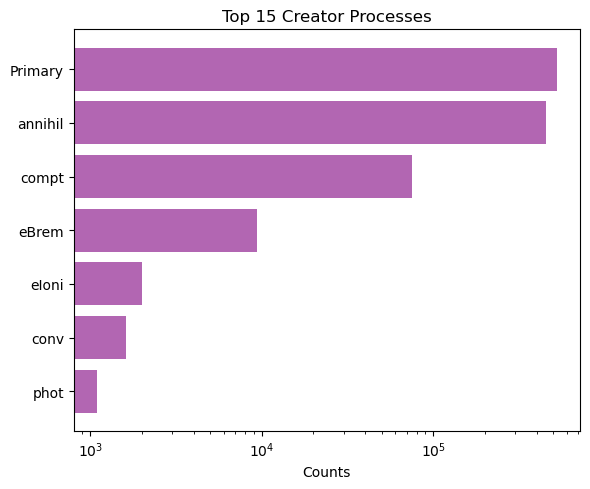

In [18]:
unique_procs, proc_counts = np.unique(flat_process, return_counts=True)
proc_labels = [process_map.get(pid, f"ID {pid}") for pid in unique_procs]

sorted_indices = np.argsort(proc_counts)[::-1]
sorted_counts = proc_counts[sorted_indices]
sorted_labels = np.array(proc_labels)[sorted_indices]

top_n = 15
if len(sorted_counts) > top_n:
    sorted_counts = sorted_counts[:top_n]
    sorted_labels = sorted_labels[:top_n]


plt.figure(figsize=(6, 5))
plt.barh(range(len(sorted_counts)), sorted_counts, color="purple", alpha=0.6)
plt.yticks(range(len(sorted_counts)), sorted_labels)
plt.xlabel("Counts")
plt.title(f"Top {top_n} Creator Processes")
plt.gca().invert_yaxis()
plt.xscale("log")
plt.tight_layout()
plt.show()


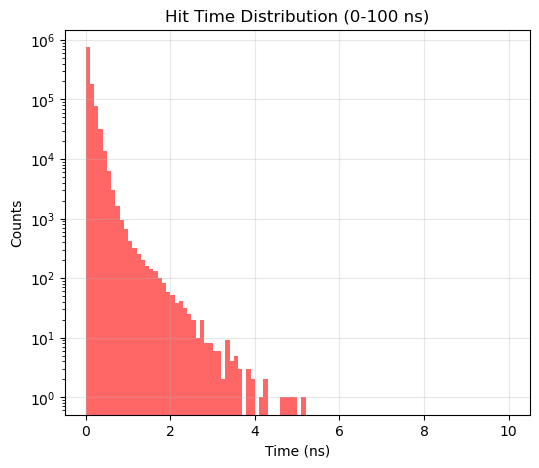

In [19]:
plt.figure(figsize=(6, 5))
plt.hist(flat_time, bins=100, range=(0, 10), color="red", alpha=0.6)
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
plt.title("Hit Time Distribution (0-100 ns)")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.show()

# 每个事件的能量沉积与物理过程贡献分析

### Event Level Edep 

分别画出事件的总能量沉积, 和分粒子的能量沉积


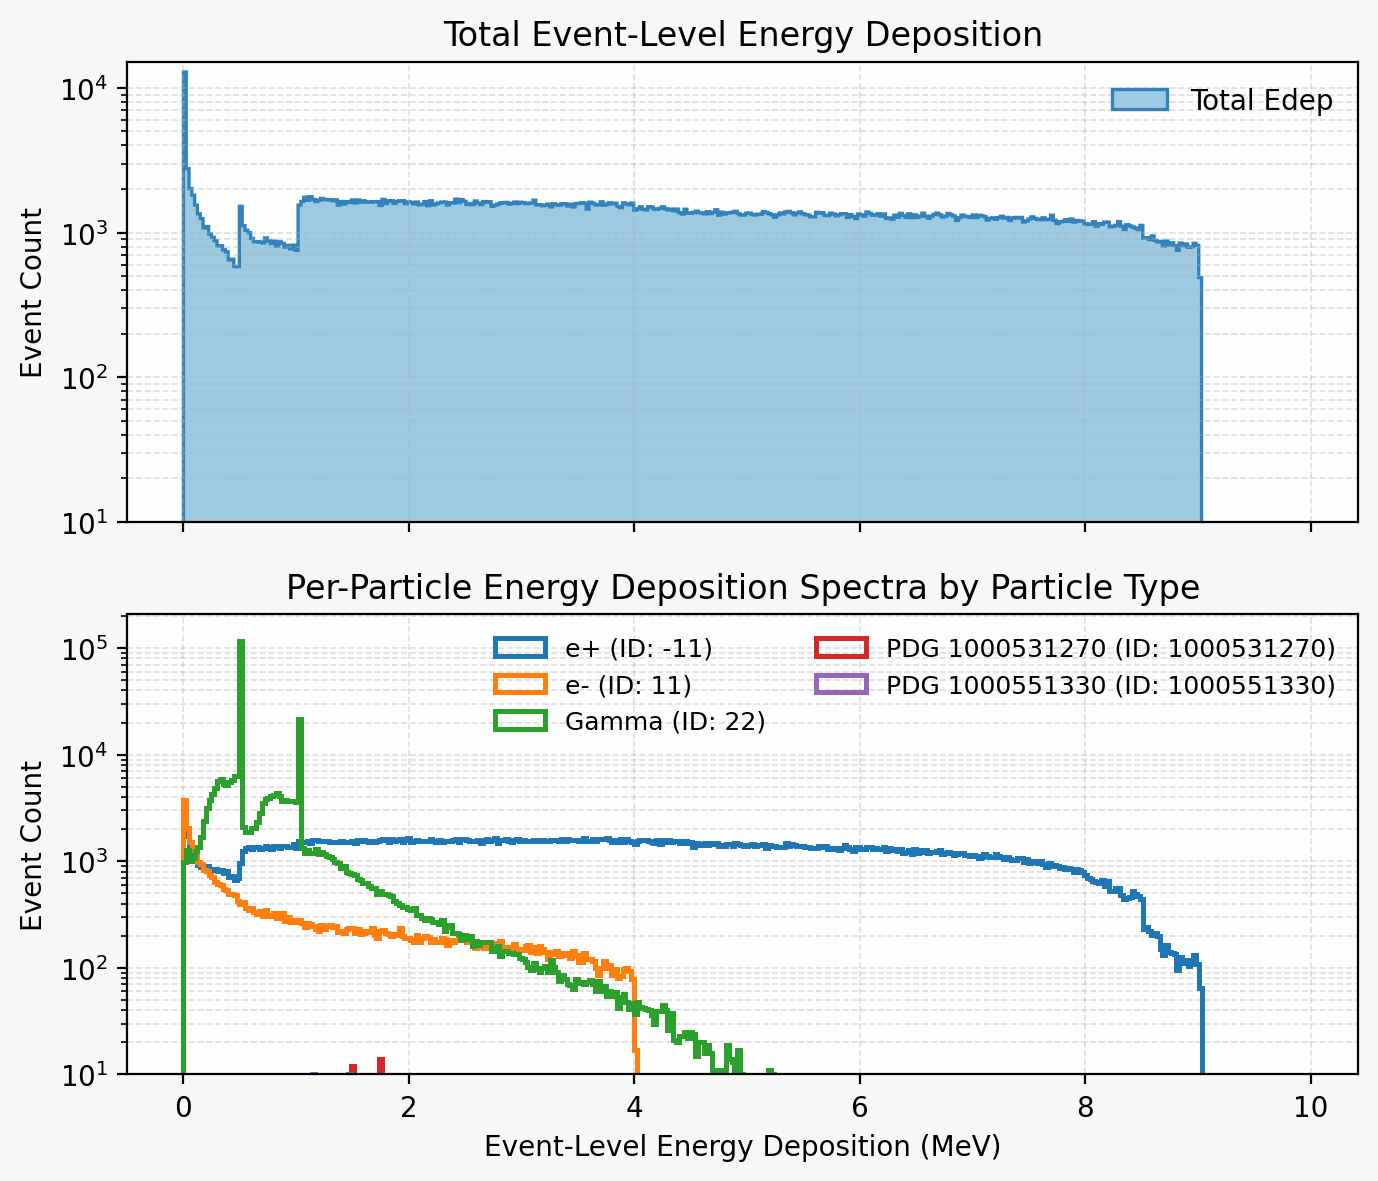

In [24]:
%config InlineBackend.figure_format = "retina"

unique_pdgs = np.unique(flat_pdg)
pdg_names = {22: "Gamma", 11: "e-", -11: "e+", 13: "mu-", -13: "mu+", 2112: "Neutron", 2212: "Proton", 1000020040: "Alpha"}

max_range = float(np.max(data["TotalEdep"])) * 1.1

fig, axes = plt.subplots(2, 1, figsize=(7, 6), sharex=True, facecolor="#f7f7f7")
for ax in axes:
    ax.set_facecolor("#fdfdfd")
    ax.set_ylabel("Event Count")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.4)

# 上图：总能量沉积谱
axes[0].hist(
    data["TotalEdep"],
    bins=400,
    range=(0, max_range),
    histtype="stepfilled",
    color="#9ecae1",
    edgecolor="#3182bd",
    linewidth=1.2,
    label="Total Edep",
)
axes[0].set_title("Total Event-Level Energy Deposition")
axes[0].legend(loc="upper right", frameon=False)
axes[0].set_ylim(10, None)

# 下图：按粒子类型分类的能量沉积谱
for pid in unique_pdgs:
    particle_hits = df_hits[df_hits["pdg"] == pid]
    if particle_hits.empty:
        continue
    particle_event_edep = particle_hits.groupby("EventID")["edep"].sum()
    label = f"{pdg_names.get(pid, f'PDG {pid}')} (ID: {pid})"
    axes[1].hist(
        particle_event_edep,
        bins=400,
        range=(0, max_range),
        histtype="step",
        linewidth=1.8,
        label=label,
    )

axes[1].set_xlabel("Event-Level Energy Deposition (MeV)")
axes[1].set_title("Per-Particle Energy Deposition Spectra by Particle Type")
axes[1].legend(loc="upper right", fontsize=9, ncol=2, frameon=False)
axes[1].set_ylim(10, None)

plt.tight_layout()
plt.show()

In [29]:
data

<Array [{EventID: 0, TotalEdep: ..., ...}, ...] type='500000 * {EventID: in...'>

In [ ]:
from math import gamma


如何检查每个事件种由正电子产生的 gamma()

<Array [[-0.985, 0.985], ..., [-0.832, ...]] type='500000 * var * float64'>

In [ ]:
import awkward as ak
import numpy as np

# 假设 data 是你的 awkward array
# 这里模拟一个示例
# 实际中，你需要加载你的 data

# 示例数据
data = ak.Array({"CrystalPDG": [[22, 11, 22], [11, 22], [22, 22, 11]], "CrystalTrackLength": [[1.0, 2.0, 3.0], [4.0, 5.0], [6.0, 7.0, 8.0]]})

print("原始数据:")
print(data)

# 筛选 gamma (PDG=22) 的 track length
gamma_mask = data["CrystalPDG"] == 22
gamma_track_lengths = data["CrystalTrackLength"][gamma_mask]

print("\nGamma track lengths per event:")
print(gamma_track_lengths)

# 每个事件的 gamma track length 总和
gamma_total_per_event = ak.sum(gamma_track_lengths, axis=-1)
print("\n每个事件的 gamma track length 总和:")
print(gamma_total_per_event)

In [34]:
data

<Array [{EventID: 0, TotalEdep: ..., ...}, ...] type='500000 * {EventID: in...'>

In [36]:
# 每个事件中所有 PrimaryDirX 的和
ak.sum(data["CrystalTrackLength"], axis=-1)

<Array [0.433, 93.3, 91.5, ..., 0.0302, 66.2, 61.7] type='500000 * float64'>

In [48]:
# 筛选 gamma 的 track length

# 方法1: 使用 Awkward Array (与你的原始代码类似)
gamma_mask = data["CrystalPDG"] == 22
gamma_track_lengths = data["CrystalTrackLength"][gamma_mask]
gamma_total_per_event = ak.sum(gamma_track_lengths, axis=-1)[1:]

print("每个事件的 gamma track length 总和 (前10个事件):")
print(gamma_total_per_event[:11])

# 方法2: 使用 DataFrame (更直观)
gamma_track_per_event_df = df_hits[df_hits["pdg"] == 22].groupby("EventID")["trackLength"].sum()

# 对齐索引以便比较
gamma_track_per_event_aligned = gamma_track_per_event_df.reindex(range(1, len(gamma_total_per_event) + 1), fill_value=0)

print("\n使用 DataFrame 的结果 (前10个事件):")
print(gamma_track_per_event_df.head(10))

# 验证两者是否一致 (使用 allclose 处理浮点精度)
non_zero_mask = gamma_total_per_event > 0
comparison = np.allclose(gamma_total_per_event[non_zero_mask], gamma_track_per_event_aligned.values[non_zero_mask], rtol=1e-10)
print(f"\n两种方法结果是否一致: {comparison}")

每个事件的 gamma track length 总和 (前10个事件):
[32.1, 77.6, 14.7, 8.4, 5.75, 76.6, 9.16, 43.7, 29.9, 0, 33.4]

使用 DataFrame 的结果 (前10个事件):
EventID
1     32.095727
2     77.606562
3     14.693585
4      8.399823
5      5.745696
6     76.582564
7      9.160104
8     43.722085
9     29.943606
11    33.355880
Name: trackLength, dtype: float64

两种方法结果是否一致: True


### Gamma Tracklength

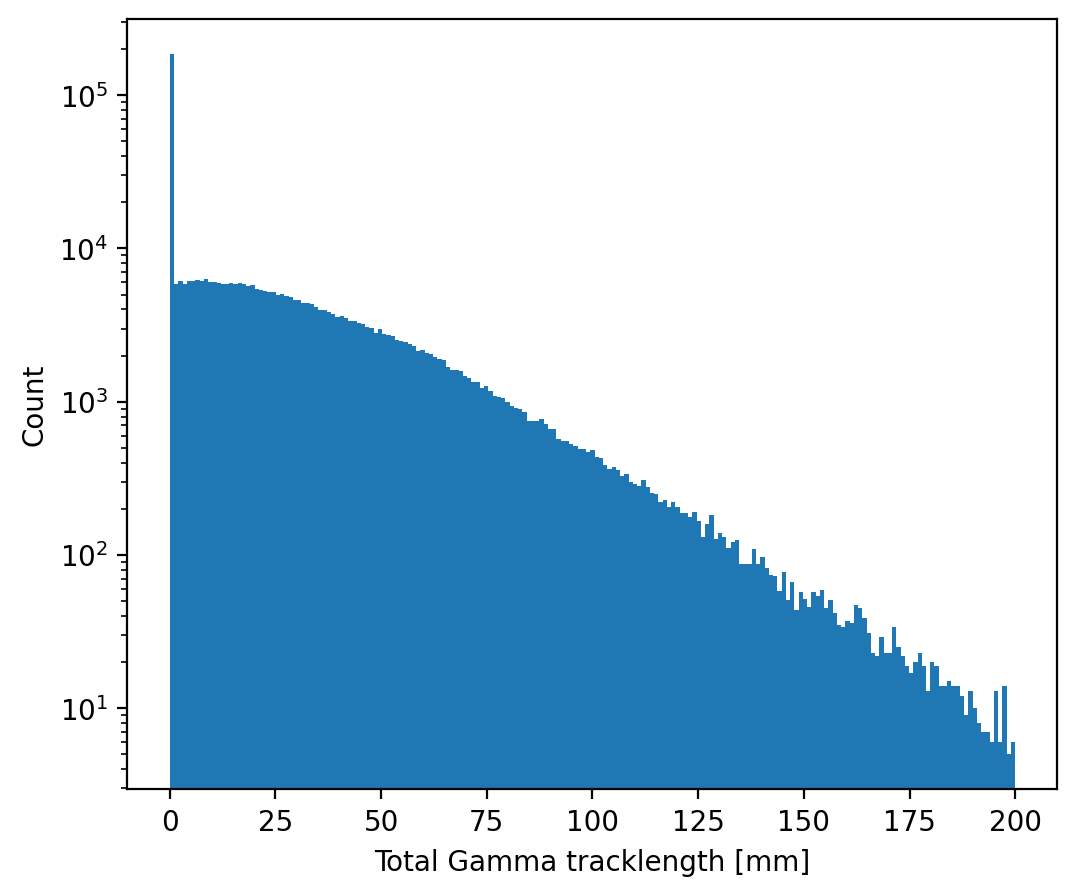

In [56]:
plt.figure(figsize=(6, 5))
plt.hist(gamma_total_per_event, bins=np.linspace(0, 200, 200))

plt.xlabel("Total Gamma tracklength [mm]")
plt.ylabel("Count")
plt.yscale("log")

正电子产生的 gamma Track Length 分析

含有 gamma 的事件总数: 319639
其中由正电子产生的 gamma 的事件数: 74913
占比: 23.4%

所有 gamma track length 总和: 11279344.65 mm
正电子产生的 gamma track length 总和: 4015772.95 mm
占比: 35.6%

正电子产生的 gamma track length 统计:
  最小值: 0.42 mm
  最大值: 323.11 mm
  平均值: 53.61 mm
  中位数: 40.81 mm

前10个有正电子产生的 gamma 的事件:
EventID
0      76.742483
1      39.797802
2      15.903574
3      94.375027
5      35.613959
6      32.845361
7      46.713484
9     138.414624
10     52.761797
15     15.510724
Name: trackLength, dtype: float64


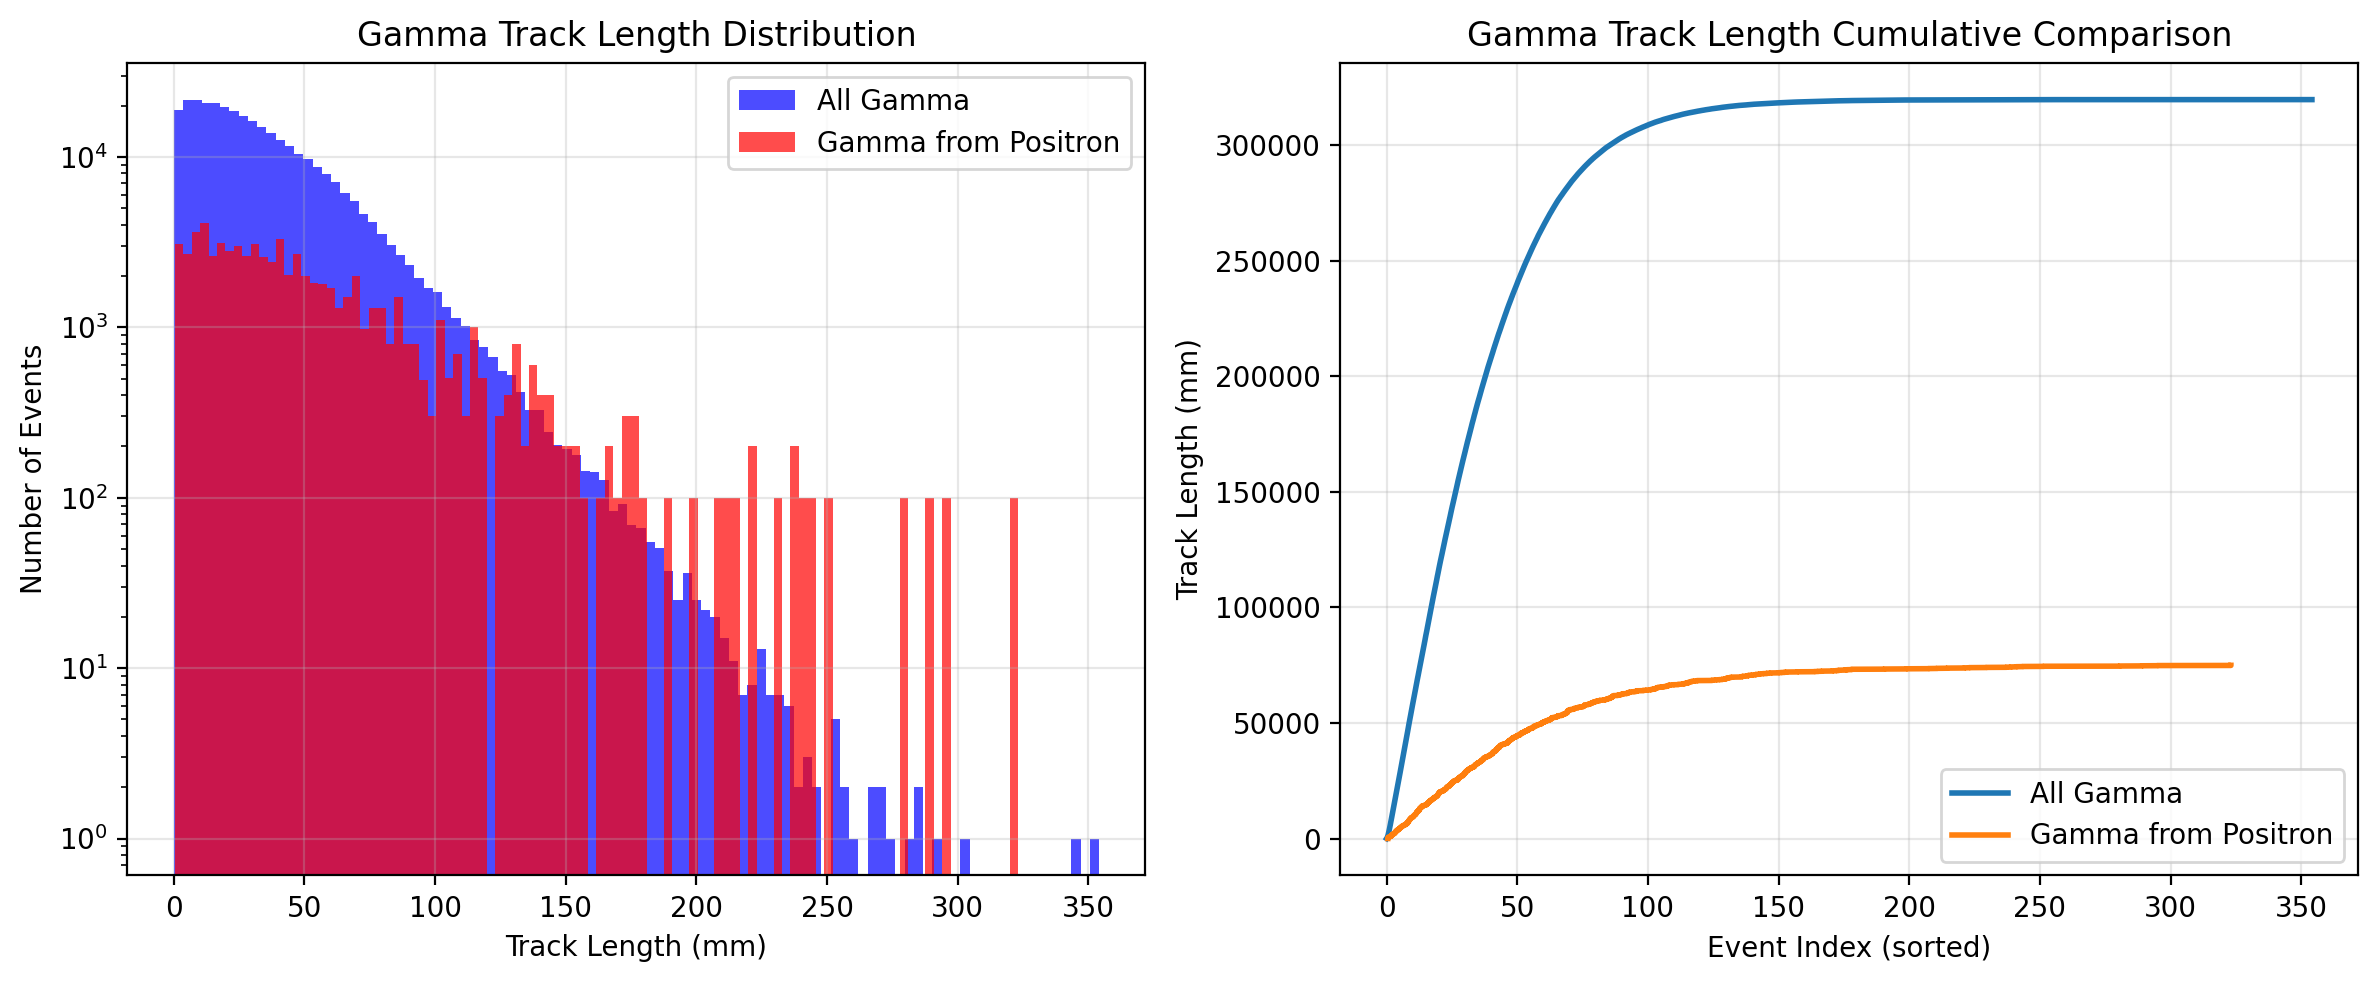

In [141]:
# ==========================================
# 进一步筛选：正电子产生的 gamma
# ==========================================

# 1. 构建粒子关系映射表 (TrackID -> 粒子信息)
track_info = df_hits[["EventID", "trackID", "pdg", "parentID"]].drop_duplicates()

# 2. 对 df_hits 进行扩展，添加父粒子的 PDG 信息
df_hits_extended = df_hits.copy()
df_hits_extended = pd.merge(df_hits_extended, track_info[["EventID", "trackID", "pdg"]].rename(columns={"trackID": "parentID", "pdg": "pdg_parent"}), on=["EventID", "parentID"], how="left")

# 3. 筛选条件：gamma (PDG=22) 且由正电子 (PDG=-11) 产生
mask_gamma_from_positron = (df_hits_extended["pdg"] == 22) & (df_hits_extended["pdg_parent"] == -11)

# 4. 计算每个事件中由正电子产生的 gamma 的总 track length
gamma_from_pos_per_event = df_hits_extended[mask_gamma_from_positron].groupby("EventID")["trackLength"].sum()

print("=" * 80)
print("正电子产生的 gamma Track Length 分析")
print("=" * 80)

print(f"\n含有 gamma 的事件总数: {(gamma_track_per_event_df > 0).sum()}")
print(f"其中由正电子产生的 gamma 的事件数: {len(gamma_from_pos_per_event)}")
print(f"占比: {len(gamma_from_pos_per_event) / (gamma_track_per_event_df > 0).sum() * 100:.1f}%")

print(f"\n所有 gamma track length 总和: {gamma_track_per_event_df.sum():.2f} mm")
print(f"正电子产生的 gamma track length 总和: {gamma_from_pos_per_event.sum():.2f} mm")
print(f"占比: {gamma_from_pos_per_event.sum() / gamma_track_per_event_df.sum() * 100:.1f}%")

print(f"\n正电子产生的 gamma track length 统计:")
print(f"  最小值: {gamma_from_pos_per_event.min():.2f} mm")
print(f"  最大值: {gamma_from_pos_per_event.max():.2f} mm")
print(f"  平均值: {gamma_from_pos_per_event.mean():.2f} mm")
print(f"  中位数: {gamma_from_pos_per_event.median():.2f} mm")

print(f"\n前10个有正电子产生的 gamma 的事件:")
print(gamma_from_pos_per_event.head(10))

# ==========================================
# 可视化对比
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 左图：所有 gamma 的 track length 分布
axes[0].hist(gamma_track_per_event_df[gamma_track_per_event_df > 0], bins=100, alpha=0.7, color="blue", label="All Gamma")
axes[0].hist(gamma_from_pos_per_event, bins=100, alpha=0.7, color="red", label="Gamma from Positron")
axes[0].set_xlabel("Track Length (mm)")
axes[0].set_ylabel("Number of Events")
axes[0].set_title("Gamma Track Length Distribution")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 右图：累积分布
sorted_all_gamma = np.sort(gamma_track_per_event_df[gamma_track_per_event_df > 0].values)
sorted_pos_gamma = np.sort(gamma_from_pos_per_event.values)

axes[1].plot(sorted_all_gamma, np.arange(len(sorted_all_gamma)), label="All Gamma", linewidth=2)
axes[1].plot(sorted_pos_gamma, np.arange(len(sorted_pos_gamma)), label="Gamma from Positron", linewidth=2)
axes[1].set_xlabel("Event Index (sorted)")
axes[1].set_ylabel("Track Length (mm)")
axes[1].set_title("Gamma Track Length Cumulative Comparison")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 物理过程的能量贡献占比


In [21]:
data[4]

<Record {EventID: 4, TotalEdep: 6, ...} type='{EventID: int32, TotalEdep: f...'>

In [22]:
# Awkward Array (ak) 基础操作演示
# Awkward Array 专门用于处理不规则数据（如每个事件有不同数量的 Hit）

import awkward as ak

print(f"数据包含的字段: {data.fields}")

# 1. 访问 Jagged Array (参差数组/变长数组)
# CrystalEdep 是每个事件中所有 Crystal 的沉积能量列表
crystal_edeps = data["CrystalEdep"]
print(f"\n--- Jagged Array 示例 (前3个事件) ---")
print(crystal_edeps[:3])

# 2. 聚合操作 (axis=1 表示在事件内部进行操作)
# 计算每个事件的 Hit 数量
num_hits = ak.num(crystal_edeps, axis=1)
# 计算每个事件的总能量 (验证 TotalEdep)
sum_edep = ak.sum(crystal_edeps, axis=1)

print(f"\n--- 聚合操作 ---")
print(f"Hit 数量 (前5个): {num_hits[:5]}")
print(f"求和能量 (前5个): {sum_edep[:5]}")

# 3. 过滤 (Masking)
# 3.1 事件级过滤: 选择 Hit 数 > 5 的事件
complex_events = data[num_hits > 5]
print(f"\n--- 过滤 ---")
print(f"复杂事件数 (Hits > 5): {len(complex_events)}")

# 3.2 Hit 级过滤: 仅保留能量 > 0.1 MeV 的 Hit
# 注意：这会保留事件结构，但每个事件中的 Hit 列表会变短
hard_hits = crystal_edeps[crystal_edeps > 0.1]
print(f"硬 Hit (>0.1 MeV) 结构 (前3个事件):\n{hard_hits[:3]}")

# 4. 展平 (Flatten)
# 将所有事件的 Hit 合并成一个大的一维数组 (常用于画总体分布)
flat_edeps = ak.flatten(crystal_edeps)
print(f"\n--- 展平 ---")
print(f"所有 Hit 展平后的长度: {len(flat_edeps)}")

数据包含的字段: ['EventID', 'TotalEdep', 'HitCount', 'CrystalID', 'CrystalEdep', 'CrystalTime', 'CrystalPosX', 'CrystalPosY', 'CrystalPosZ', 'CrystalPDG', 'CrystalParentID', 'CrystalDirX', 'CrystalDirY', 'CrystalDirZ', 'CrystalKineticEnergy', 'CrystalProcessID', 'CrystalTrackLength', 'CrystalTrackID', 'PrimaryPDG', 'PrimaryEnergy', 'PrimaryPosX', 'PrimaryPosY', 'PrimaryPosZ', 'PrimaryDirX', 'PrimaryDirY', 'PrimaryDirZ']

--- Jagged Array 示例 (前3个事件) ---
[[0.332], [4.98, 0.00503, ..., 0.336], [5.03, 0.794, 1.08, 0.972, 0.731]]

--- 聚合操作 ---
Hit 数量 (前5个): [1, 4, 5, 2, 2]
求和能量 (前5个): [0.332, 5.68, 8.6, 1.06, 6]

--- 过滤 ---
复杂事件数 (Hits > 5): 5383
硬 Hit (>0.1 MeV) 结构 (前3个事件):
[[0.332], [4.98, 0.36, 0.336], [5.03, 0.794, 1.08, 0.972, 0.731]]

--- 展平 ---
所有 Hit 展平后的长度: 1068351


In [23]:
process_list = total_by_process.index.tolist()
n_cols = 3
n_rows = int(np.ceil(len(process_list) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.2 * n_cols, 3.5 * n_rows), sharex=False)
axes = axes.flatten()

for ax, process in zip(axes, process_list):
    values = process_contribution.loc[process_contribution["process_name"] == process, "edep_by_process"]
    bins = np.linspace(0, values.max() * 1.05, 120)
    ax.hist(values, bins=bins, color="steelblue", alpha=0.7)
    ax.set_title(f"{process} (ΣE = {values.sum():.1f} MeV)")
    ax.set_xlabel("Deposited Energy (MeV)")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")
    ax.grid(True, axis="y", alpha=0.3)

for ax in axes[len(process_list) :]:
    ax.axis("off")

plt.tight_layout()
plt.show()


NameError: name 'total_by_process' is not defined

电子来源详细分析:
总事件数: 100000
含有正电子的事件: 100000
含有正电子衍生电子的事件: 0


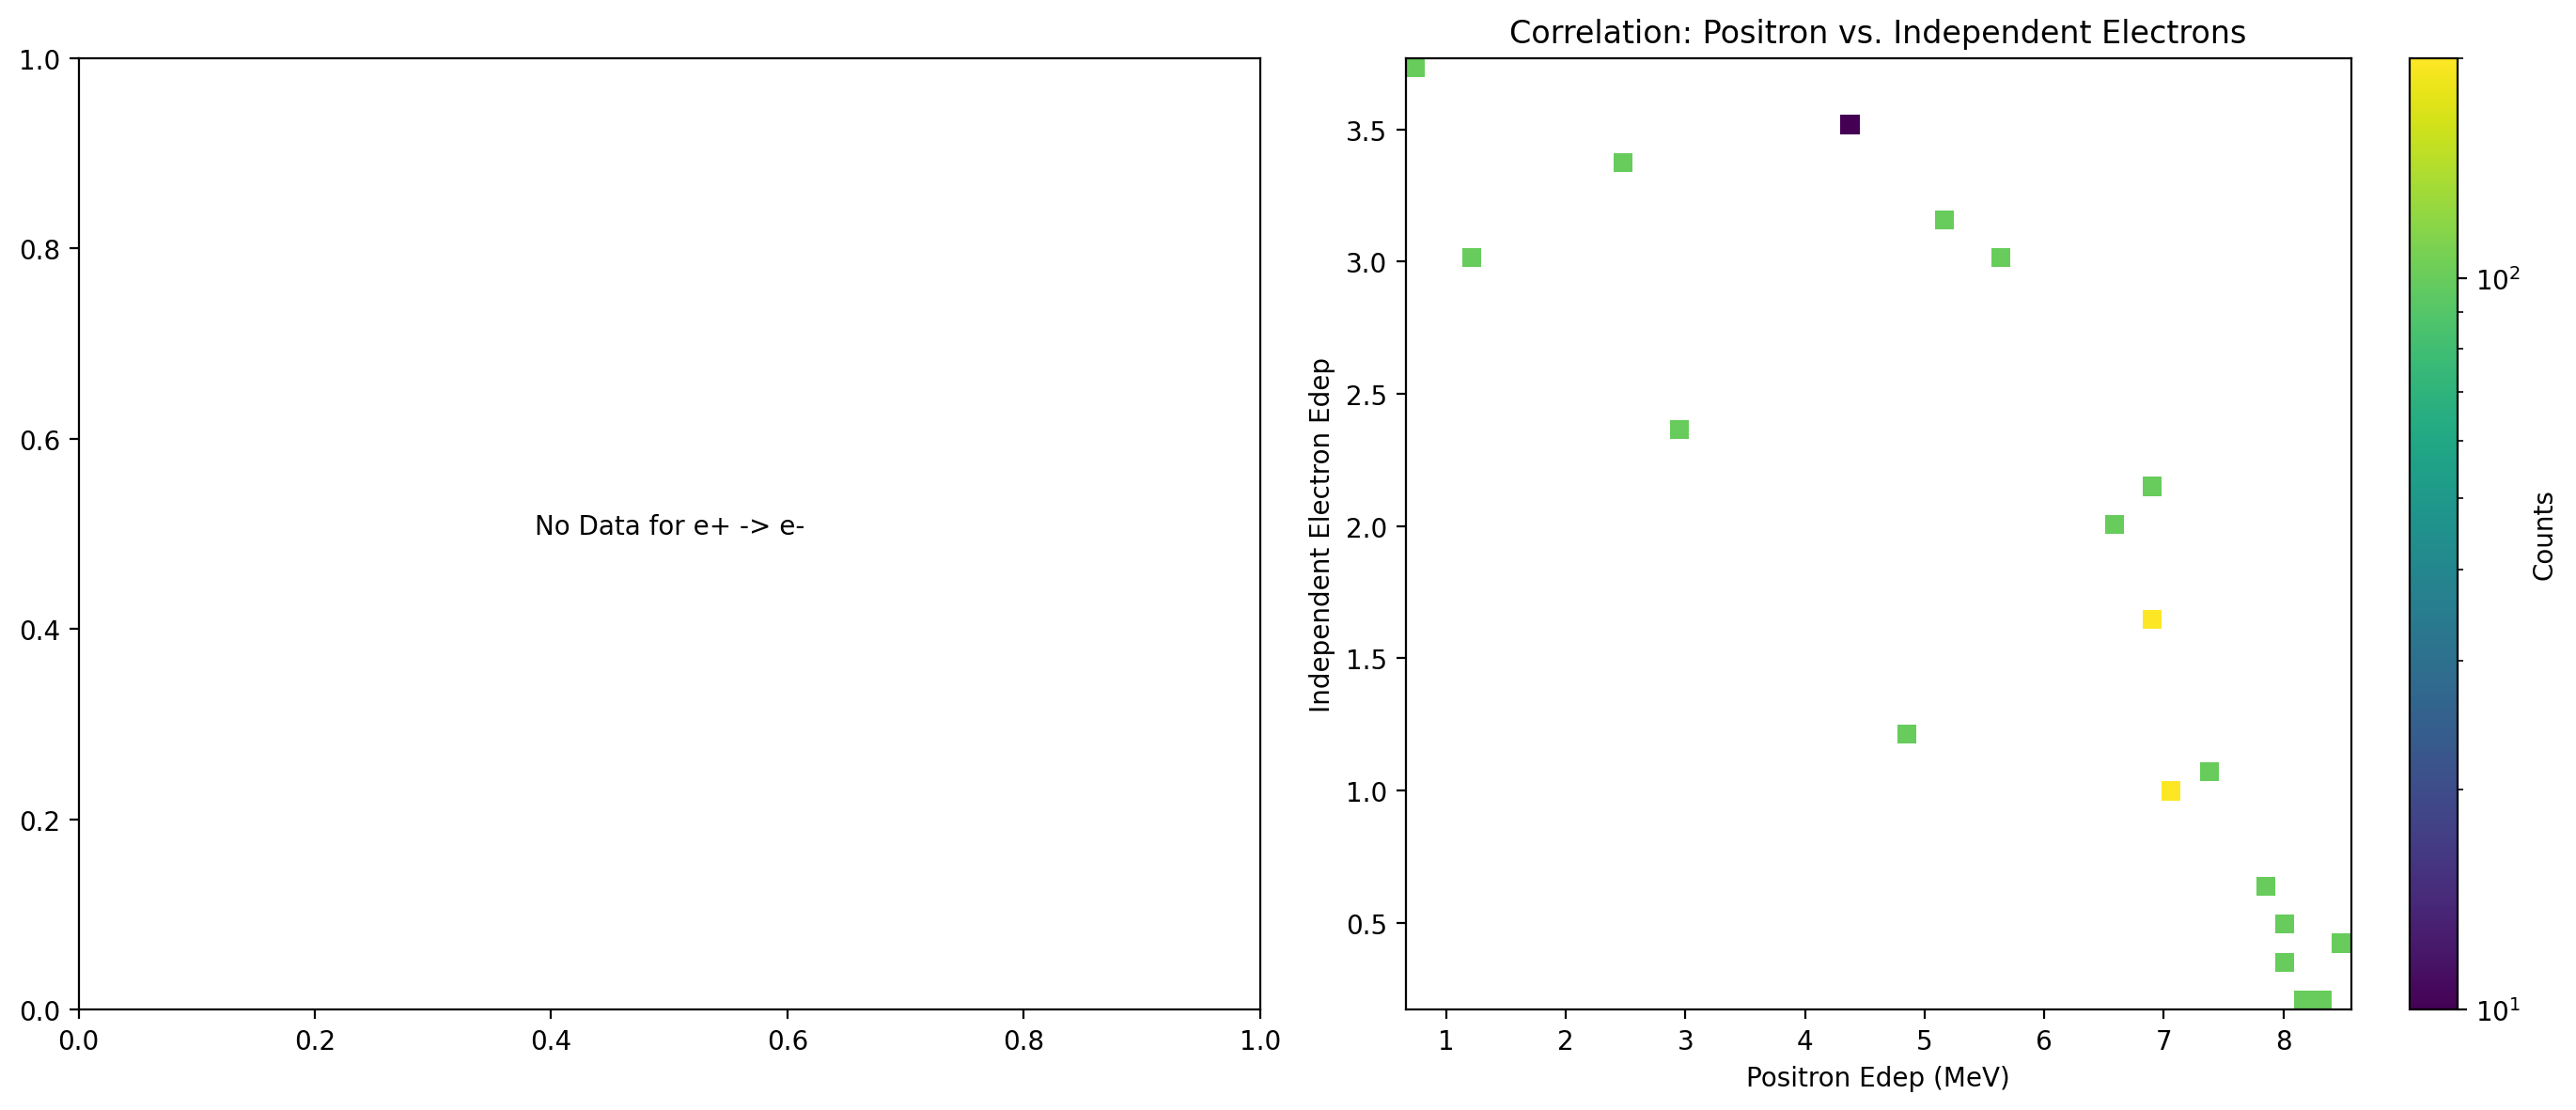

In [140]:
# filepath:
# ...existing code...

# ==========================================
# 区分电子来源：是否由正电子产生
# ==========================================

# 1. 构建 TrackID -> PDG 的映射表
# 我们需要知道每个 parentID 对应的是什么粒子
# 注意：这里假设父粒子至少在探测器中留下了一个 Hit。如果父粒子完全没有沉积能量，这种方法会漏掉（通常带电粒子都会有 Hit）
track_info = df_hits[["EventID", "trackID", "pdg"]].drop_duplicates()

# 2. 将 Hit 数据与 Track 信息合并，以获取父粒子的 PDG
# left_on: 当前 Hit 的 parentID
# right_on: Track 表的 trackID
df_hits_with_parent = pd.merge(df_hits, track_info, left_on=["EventID", "parentID"], right_on=["EventID", "trackID"], how="left", suffixes=("", "_parent"))

# 3. 提取正电子的能量沉积 (按事件)
pos_edep = df_hits_with_parent[df_hits_with_parent["pdg"] == -11].groupby("EventID")["edep"].sum().rename("Positron_Edep")

# 4. 提取 "正电子产生的电子" (Daughter Electrons)
# 条件: 当前是电子 (11) AND 父粒子是正电子 (-11)
mask_e_from_pos = (df_hits_with_parent["pdg"] == 11) & (df_hits_with_parent["pdg_parent"] == -11)
e_from_pos_edep = df_hits_with_parent[mask_e_from_pos].groupby("EventID")["edep"].sum().rename("E_from_Pos_Edep")

# 5. 提取 "其他电子" (Independent Electrons)
# 条件: 当前是电子 (11) AND (父粒子不是正电子 OR 是初级粒子)
mask_e_other = (df_hits_with_parent["pdg"] == 11) & (df_hits_with_parent["pdg_parent"] != -11)
e_other_edep = df_hits_with_parent[mask_e_other].groupby("EventID")["edep"].sum().rename("E_Other_Edep")

# 6. 合并所有数据
df_corr_detailed = pd.concat([pos_edep, e_from_pos_edep, e_other_edep], axis=1).fillna(0)

print("电子来源详细分析:")
print(f"总事件数: {len(df_corr_detailed)}")
print(f"含有正电子的事件: {(df_corr_detailed['Positron_Edep'] > 0).sum()}")
print(f"含有正电子衍生电子的事件: {(df_corr_detailed['E_from_Pos_Edep'] > 0).sum()}")

# ==========================================
# 可视化
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 图 1: 正电子能量 vs 正电子产生的次级电子能量
# 物理意义: 正电子损失能量产生 delta 射线或电离电子的相关性
mask1 = (df_corr_detailed["Positron_Edep"] > 0) & (df_corr_detailed["E_from_Pos_Edep"] > 0)
if mask1.sum() > 0:
    h1 = axes[0].hist2d(df_corr_detailed[mask1]["Positron_Edep"], df_corr_detailed[mask1]["E_from_Pos_Edep"], bins=50, norm=LogNorm(), cmap="inferno")
    plt.colorbar(h1[3], ax=axes[0], label="Counts")
    axes[0].set_xlabel("Positron Edep (MeV)")
    axes[0].set_ylabel("Secondary Electron Edep (from e+)")
    axes[0].set_title("Correlation: Positron vs. Its Daughter Electrons")
else:
    axes[0].text(0.5, 0.5, "No Data for e+ -> e-", ha="center")

# 图 2: 正电子能量 vs 其他电子能量
# 物理意义: 检查是否是独立的两个粒子（如对产生出来的 e+ 和 e-）
mask2 = (df_corr_detailed["Positron_Edep"] > 0) & (df_corr_detailed["E_Other_Edep"] > 0)
if mask2.sum() > 0:
    h2 = axes[1].hist2d(df_corr_detailed[mask2]["Positron_Edep"], df_corr_detailed[mask2]["E_Other_Edep"], bins=50, norm=LogNorm(), cmap="viridis")
    plt.colorbar(h2[3], ax=axes[1], label="Counts")
    axes[1].set_xlabel("Positron Edep (MeV)")
    axes[1].set_ylabel("Independent Electron Edep")
    axes[1].set_title("Correlation: Positron vs. Independent Electrons")

    # 如果是对产生 (Pair Production)，通常 e+ 和 e- 能量会有某种负相关（总能量守恒）
    # 画一条简单的参考线 (假设总能量是某个典型值，例如入射光子能量)
    # max_e = df_corr_detailed[mask2].max().max()
    # axes[1].plot([0, max_e], [max_e, 0], 'r--', alpha=0.5, label="Energy Conservation Trend")

plt.tight_layout()
plt.show()

### Primary 过程的物理含义分析

在 Geant4 中，`Primary` (processID=0) 并不代表某个具体的物理过程，而是标记**初级粒子**直接造成的能量沉积。

初级粒子损失能量的主要机制取决于粒子类型：
- **电子/正电子 (e⁻/e⁺)**: 主要通过**电离损失** (ionization) 和**韧致辐射** (bremsstrahlung)
- **光子 (γ)**: 通过**光电效应** (photoelectric)、**康普顿散射** (Compton) 或**对产生** (pair production)
- **重带电粒子**: 主要通过电离损失



### TrackLength 的分布

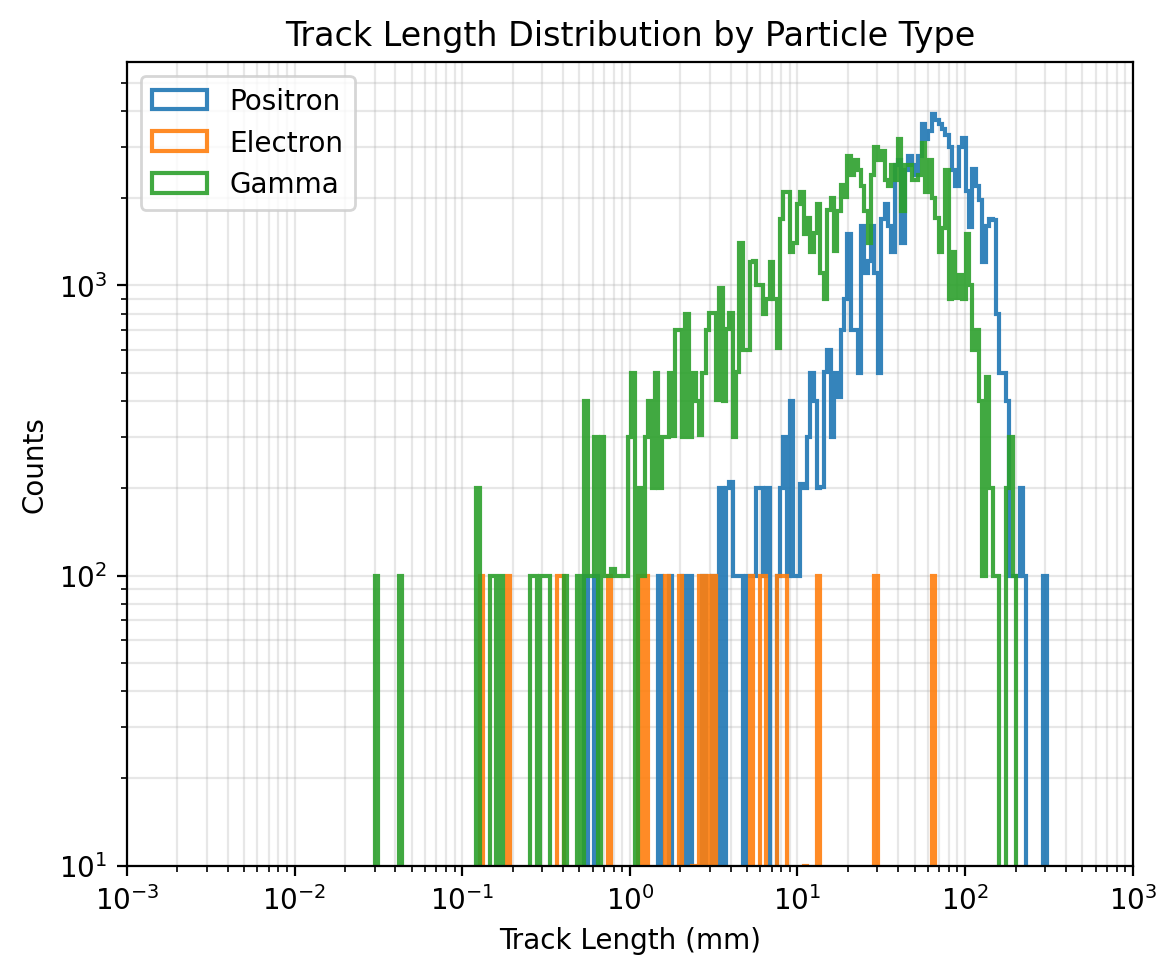

In [139]:
# 电子与正电子反应的 track length 分布
target_pids = [-11, 11, 22, 13, -13, 2112, 2212]
track_length_data = {}
for pid in target_pids:
    tracks = df_hits.loc[(df_hits["pdg"] == pid) & (df_hits["trackLength"] > 0), "trackLength"]
    if not tracks.empty:
        track_length_data[pid] = tracks

if track_length_data:
    min_track = min(series.min() for series in track_length_data.values())
    max_track = max(series.max() for series in track_length_data.values())
    common_bins = np.logspace(np.log10(min_track), np.log10(max_track), 200)

    plt.figure(figsize=(6, 5))
    colors = plt.cm.tab10(range(len(track_length_data)))
    for (pid, series), color in zip(track_length_data.items(), colors):
        label = pdg_name_map.get(pid, f"PDG {pid}")
        plt.hist(series, bins=common_bins, histtype="step", linewidth=1.5, alpha=0.9, color=color, label=label)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Track Length (mm)")
    plt.ylabel("Counts")
    plt.xlim(1e-3, 1e3)
    plt.ylim(10, None)
    plt.title("Track Length Distribution by Particle Type")
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()

### gamma 生成的过程

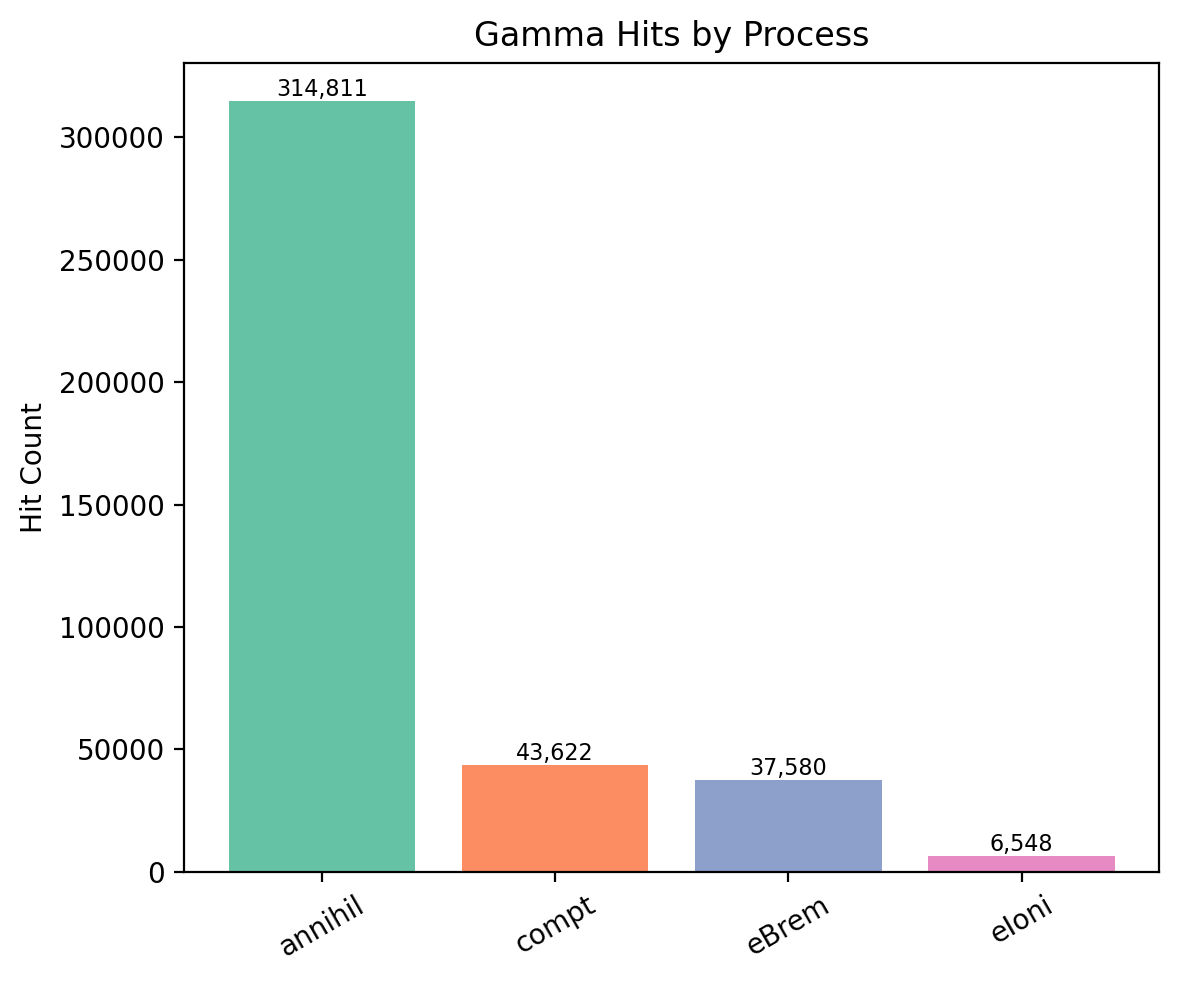

In [ ]:
# 可视化伽马产生过程统计
fig, axes = plt.subplots(1, figsize=(6, 5))
axes = [axes]
# 1. 各过程 Hit 数
colors = plt.cm.Set2(range(len(gamma_process_summary)))
axes[0].bar(process_names := gamma_process_summary.index, gamma_process_summary["hit_count"], color=colors)
axes[0].set_ylabel("Hit Count")
axes[0].set_title("Gamma Hits by Process")
axes[0].tick_params(axis="x", rotation=30)
for i, v in enumerate(gamma_process_summary["hit_count"]):
    axes[0].text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=8)

# # 2. 各过程沉积能量
# axes[1].bar(process_names, gamma_process_summary["total_edep"], color=colors)
# axes[1].set_ylabel("Total Deposited Energy (MeV)")
# axes[1].set_title("Deposited Energy by Process")
# axes[1].tick_params(axis="x", rotation=30)
# for i, v in enumerate(gamma_process_summary["total_edep"]):
#     axes[1].text(i, v, f"{v:.1f}", ha="center", va="bottom", fontsize=8)

# # 3. Primary / Secondary 分解（按计数）
# origin_cols = origin_breakdown.columns
# bottom = np.zeros(len(origin_breakdown))
# for col in origin_cols:
#     axes[2].bar(process_names, origin_breakdown[col], bottom=bottom, label=col)
#     bottom += origin_breakdown[col].values
# axes[2].set_ylabel("Hit Count")
# axes[2].set_title("Origin Breakdown per Process")
# axes[2].tick_params(axis="x", rotation=30)
# axes[2].legend(title="Origin")

plt.tight_layout()
plt.show()

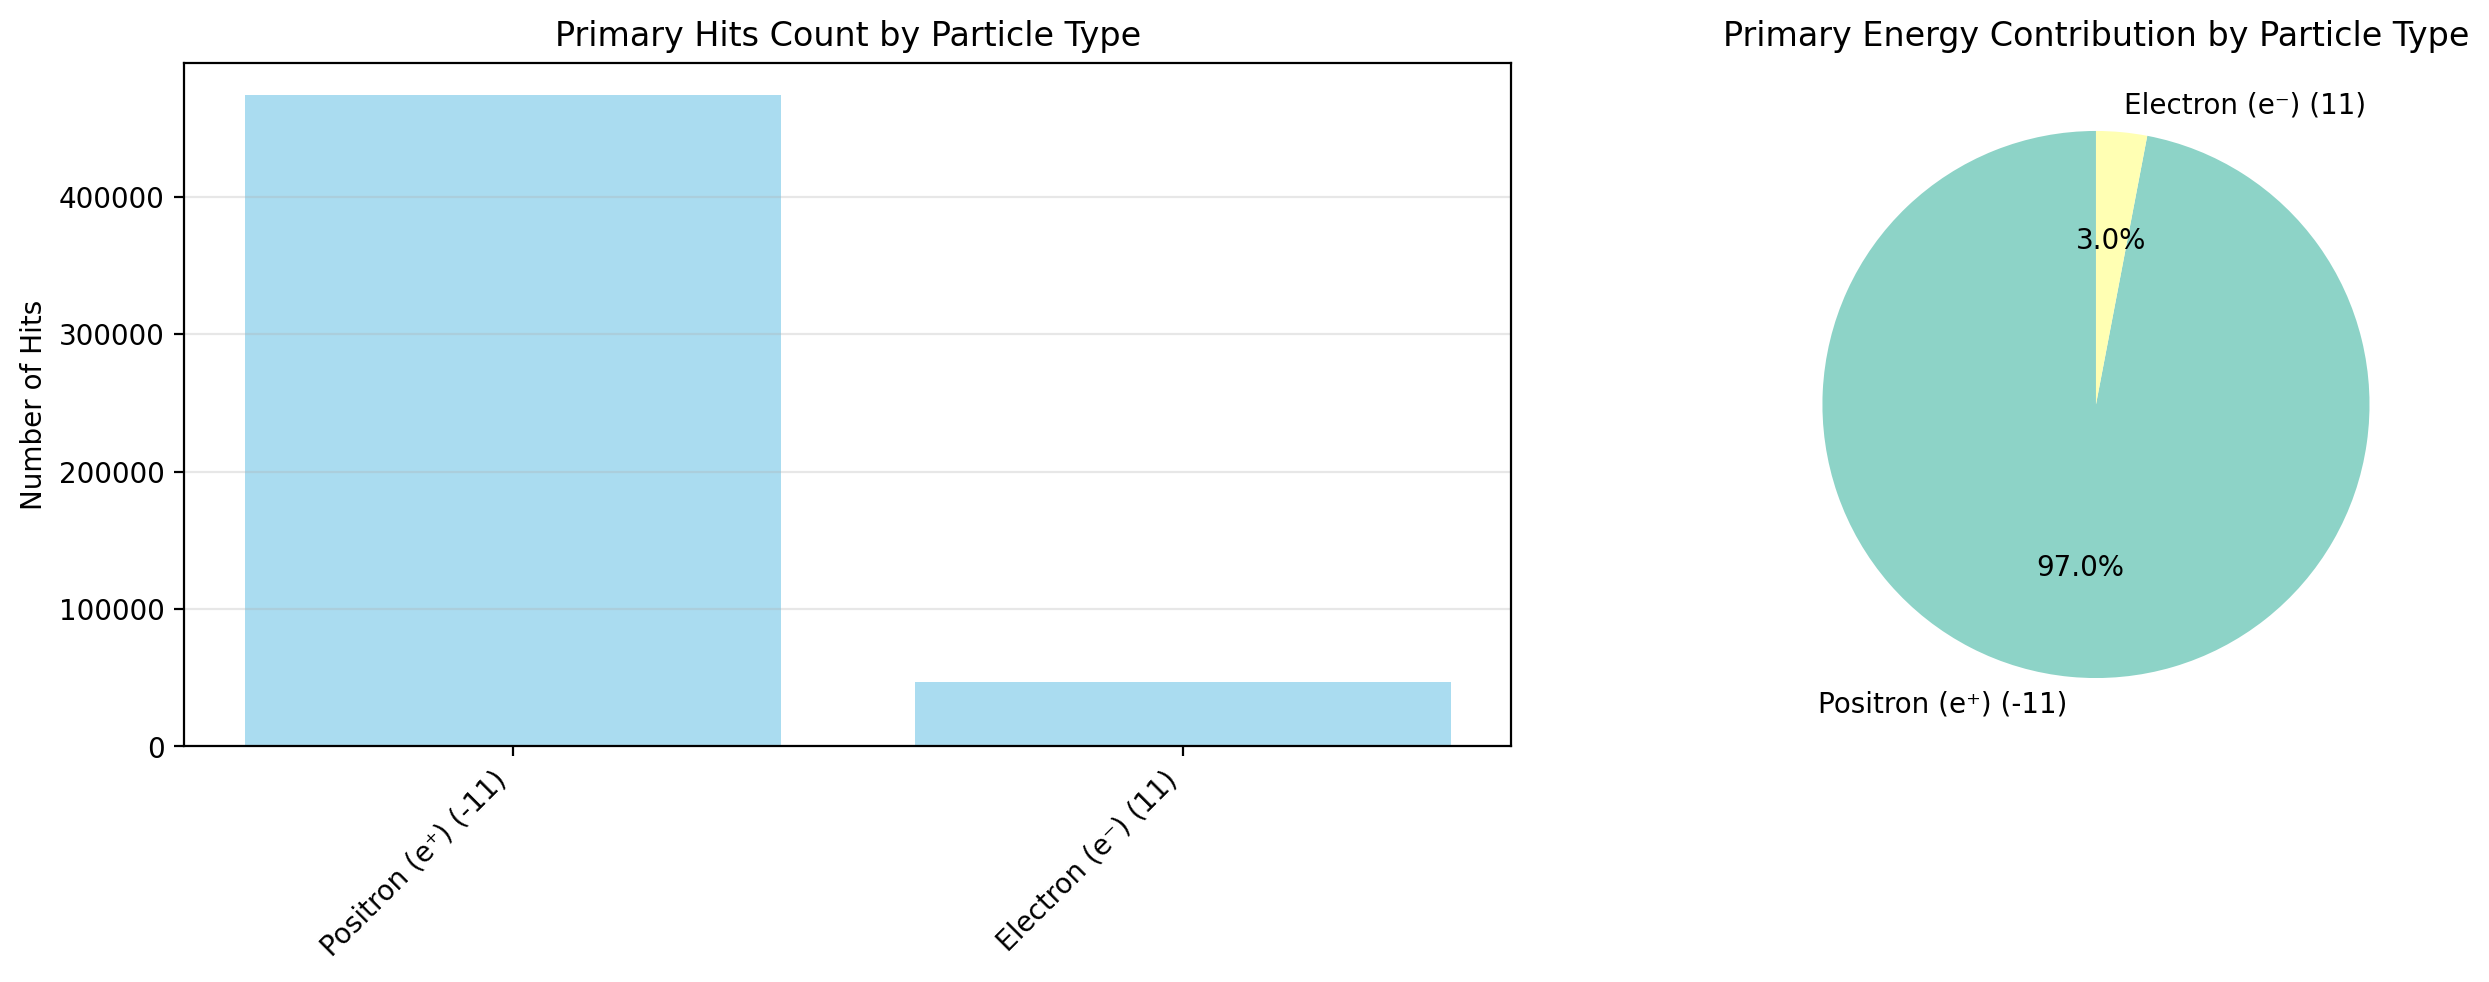

In [ ]:
# 6. 可视化 Primary 过程中粒子类型的贡献
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 左图: Hit 数量分布
particle_counts = primary_by_pdg["Hit_Count"].sort_values(ascending=False)
ax1.bar(range(len(particle_counts)), particle_counts.values, color="skyblue", alpha=0.7)
ax1.set_xticks(range(len(particle_counts)))
ax1.set_xticklabels(particle_counts.index, rotation=45, ha="right")
ax1.set_ylabel("Number of Hits")
ax1.set_title("Primary Hits Count by Particle Type")
ax1.grid(True, axis="y", alpha=0.3)

# 右图: 能量贡献饼图
energy_contrib = primary_by_pdg["Total_Energy (MeV)"].sort_values(ascending=False)
colors = plt.cm.Set3(range(len(energy_contrib)))
ax2.pie(energy_contrib, labels=energy_contrib.index, autopct="%1.1f%%", startangle=90, colors=colors)
ax2.set_title("Primary Energy Contribution by Particle Type")

plt.tight_layout()
plt.show()

# 基于事件级别的粒子分析

接下来我们按事件(Event)为单位，分析每个事件中不同粒子的贡献，包括：
- 不同粒子类型的能量沉积
- 不同粒子的Hit数量
- 径迹长度统计
- 粒子能谱分析

In [133]:
# 1. 计算每个事件中不同粒子类型的能量沉积
# 为 df_hits 添加粒子名称列
pdg_name_map = {22: "Gamma", 11: "Electron", -11: "Positron", 13: "Muon-", -13: "Muon+", 2112: "Neutron", 2212: "Proton"}
df_hits["particle_name"] = df_hits["pdg"].map(lambda x: pdg_name_map.get(x, f"PDG_{x}"))

# 按事件和粒子类型分组统计
event_particle_stats = (
    df_hits.groupby(["EventID", "particle_name"])
    .agg({
        "edep": ["sum", "mean", "count"],  # 总能量、平均能量、Hit数
        "kineticEnergy": ["mean", "max", "min"],  # 动能统计
    })
    .reset_index()
)

# 简化列名
event_particle_stats.columns = ["EventID", "Particle", "Total_Edep", "Mean_Edep", "Hit_Count", "Mean_KE", "Max_KE", "Min_KE"]

print("事件-粒子级别统计 (前20行):")
print(event_particle_stats.head(20))
print(f"\n数据形状: {event_particle_stats.shape}")
print(f"涉及的粒子类型: {event_particle_stats['Particle'].unique()}")

事件-粒子级别统计 (前20行):
    EventID  Particle  Total_Edep  Mean_Edep  Hit_Count   Mean_KE    Max_KE  \
0         0     Gamma    1.731333   0.577111          3  0.577111  1.026574   
1         0  Positron    7.290665   7.290665          1  4.000000  4.000000   
2         1     Gamma    1.243421   1.243421          1  1.243421  1.243421   
3         1  Positron    7.778222   3.889111          2  3.035420  4.000000   
4         2     Gamma    0.510999   0.255499          2  0.339173  0.510999   
5         2  Positron    8.510999   8.510999          1  4.000000  4.000000   
6         3     Gamma    2.297516   1.148758          2  1.148758  1.521001   
7         3  Positron    6.724482   6.724482          1  4.000000  4.000000   
8         4  Positron    9.021998   9.021998          1  4.000000  4.000000   
9         5     Gamma    1.177186   0.588593          2  0.348661  0.510999   
10        5  Positron    7.844812   7.844812          1  4.000000  4.000000   
11        6     Gamma    0.510999 

In [134]:
# 2. 使用 Geant4 记录的 Track Length 数据
# 现在我们直接使用 Geant4 中记录的精确 trackLength 字段
# 这比通过相邻Hit之间的距离估算更准确

print("使用 Geant4 记录的精确 Track Length 数据")
print("=" * 80)

# 计算每个事件中每种粒子的总径迹长度
track_length_stats = df_hits.groupby(["EventID", "particle_name"])["trackLength"].sum().reset_index().rename(columns={"trackLength": "Track_Length_mm", "particle_name": "Particle"})

# 合并到事件-粒子统计中
event_particle_stats = event_particle_stats.merge(track_length_stats, on=["EventID", "Particle"], how="left")

print("添加径迹长度后的统计 (前20行):")
print(event_particle_stats.head(20))
print(f"\n各粒子的平均径迹长度 (mm):")
avg_track_length = event_particle_stats.groupby("Particle")["Track_Length_mm"].mean().sort_values(ascending=False)
print(avg_track_length)

print("\n说明:")
print("  - 现在使用的是 Geant4 直接记录的 Track Length")
print("  - 每个 Hit 对应的 trackLength 是该粒子在该步骤中的路径长度")
print("  - 对每个事件中的同种粒子求和，得到该粒子的总径迹长度")

使用 Geant4 记录的精确 Track Length 数据
添加径迹长度后的统计 (前20行):
    EventID  Particle  Total_Edep  Mean_Edep  Hit_Count   Mean_KE    Max_KE  \
0         0     Gamma    1.731333   0.577111          3  0.577111  1.026574   
1         0  Positron    7.290665   7.290665          1  4.000000  4.000000   
2         1     Gamma    1.243421   1.243421          1  1.243421  1.243421   
3         1  Positron    7.778222   3.889111          2  3.035420  4.000000   
4         2     Gamma    0.510999   0.255499          2  0.339173  0.510999   
5         2  Positron    8.510999   8.510999          1  4.000000  4.000000   
6         3     Gamma    2.297516   1.148758          2  1.148758  1.521001   
7         3  Positron    6.724482   6.724482          1  4.000000  4.000000   
8         4  Positron    9.021998   9.021998          1  4.000000  4.000000   
9         5     Gamma    1.177186   0.588593          2  0.348661  0.510999   
10        5  Positron    7.844812   7.844812          1  4.000000  4.000000   
1

In [135]:
# 3. 创建事件级别的汇总表：将不同粒子的数据展开成列
# 使用透视表将每种粒子作为单独的列
event_summary = event_particle_stats.pivot_table(index="EventID", columns="Particle", values=["Total_Edep", "Hit_Count", "Track_Length_mm"], fill_value=0)

# 简化多层列名
event_summary.columns = [f"{particle}_{metric}" for metric, particle in event_summary.columns]
event_summary.reset_index(inplace=True)

# 添加事件总能量和总Hit数
event_summary["Total_Event_Edep"] = event_edep_df["total_edep"].values
event_summary["Total_Hit_Count"] = df_hits.groupby("EventID").size().values

print("事件级别汇总表 (前10个事件):")
print(event_summary.head(10))
print(f"\n汇总表形状: {event_summary.shape}")
print(f"\n列名: {list(event_summary.columns)}")

NameError: name 'event_edep_df' is not defined

In [136]:
# 4. 统计分析：各粒子在所有事件中的贡献
particle_overall_stats = (
    event_particle_stats.groupby("Particle")
    .agg({
        "Total_Edep": ["sum", "mean", "std"],
        "Hit_Count": ["sum", "mean", "std"],
        "Track_Length_mm": ["mean", "std", "max"],
        "Mean_KE": "mean",
        "EventID": "count",  # 出现在多少个事件中
    })
    .round(4)
)

particle_overall_stats.columns = [
    "Total_Energy",
    "Mean_Energy_per_Event",
    "Std_Energy",
    "Total_Hits",
    "Mean_Hits_per_Event",
    "Std_Hits",
    "Mean_Track_Length",
    "Std_Track_Length",
    "Max_Track_Length",
    "Mean_Kinetic_Energy",
    "Event_Count",
]

# 添加能量占比
total_energy = particle_overall_stats["Total_Energy"].sum()
particle_overall_stats["Energy_Percentage"] = (particle_overall_stats["Total_Energy"] / total_energy * 100).round(2)

# 按总能量排序
particle_overall_stats = particle_overall_stats.sort_values("Total_Energy", ascending=False)

print("各粒子类型的整体统计:")
print("=" * 100)
print(particle_overall_stats)
print("=" * 100)

各粒子类型的整体统计:
                Total_Energy  Mean_Energy_per_Event  Std_Energy  Total_Hits  \
Particle                                                                      
Positron         808282.4912                 8.0828      1.0616      108431   
Gamma             86609.1773                 1.0769      0.9245      144841   
Electron           3296.6391                 1.6401      1.1349        2120   
PDG_1000531270     1951.3598                 2.7877      0.7445         700   
PDG_1000551330      784.6263                 1.9567      0.4852         401   

                Mean_Hits_per_Event  Std_Hits  Mean_Track_Length  \
Particle                                                           
Positron                     1.0843    0.2953            72.1272   
Gamma                        1.8010    0.9715            58.1792   
Electron                     1.0547    0.2275             8.3478   
PDG_1000531270               1.0000    0.0000            54.7181   
PDG_1000551330            

## Cube 统计

分析每个事件中不同 Crystal 被击中的数量 (Crystal Multiplicity)

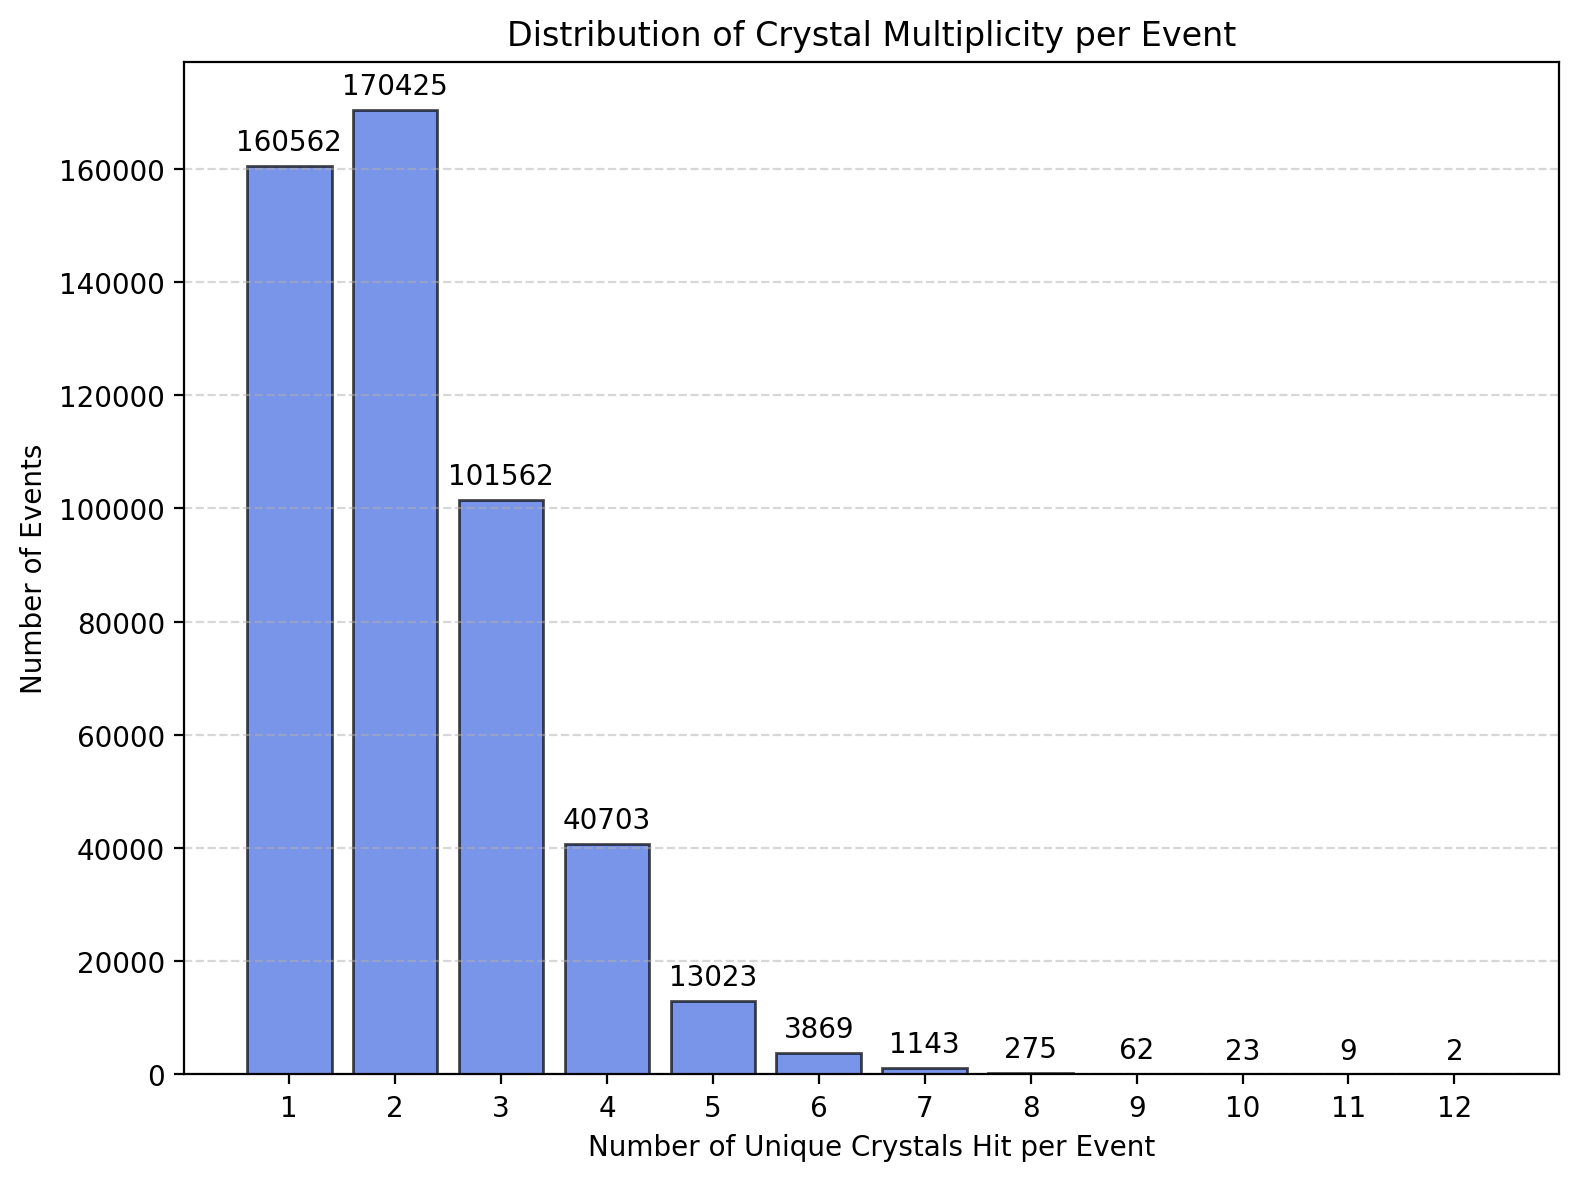

Crystal Multiplicity 统计:
  平均每个事件击中: 2.17 个 Crystal
  中位数: 2.0 个
  最大值: 12 个
  单晶体事件占比: 32.7%


In [ ]:
crystal_counts_per_event = df_hits.groupby("EventID")["crystalID"].nunique()

# 2. 绘图
plt.figure(figsize=(8, 6))

# 确定直方图的 bin 范围 (从 1 到 最大值)
max_crystals = int(crystal_counts_per_event.max())
bins = range(1, max_crystals + 2)  # +2 是为了包含最大值并在右侧留空

# 绘制直方图
n, bins, patches = plt.hist(crystal_counts_per_event, bins=bins, align="left", rwidth=0.8, color="royalblue", alpha=0.7, edgecolor="black")

plt.xlabel("Number of Unique Crystals Hit per Event")
plt.ylabel("Number of Events")
plt.title("Distribution of Crystal Multiplicity per Event")
plt.xticks(bins[:-1])  # 设置 x 轴刻度为整数
plt.grid(axis="y", linestyle="--", alpha=0.5)

# 在柱状图上方添加具体数值标签
for i in range(len(n)):
    if n[i] > 0:
        plt.text(bins[i], n[i] + max(n) * 0.01, str(int(n[i])), ha="center", va="bottom")

plt.tight_layout()
plt.show()

# 打印统计信息
print(f"Crystal Multiplicity 统计:")
print(f"  平均每个事件击中: {crystal_counts_per_event.mean():.2f} 个 Crystal")
print(f"  中位数: {crystal_counts_per_event.median()} 个")
print(f"  最大值: {crystal_counts_per_event.max()} 个")
print(f"  单晶体事件占比: {(crystal_counts_per_event == 1).mean():.1%}")

### Cube 之间的弥散程度

坐标索引解码示例 (前5行):
   crystalID  ix  iy  iz
0      70001   7   0   1
1      20601   2   6   1
2      20602   2   6   2
3      20502   2   5   2
4      10601   1   6   1


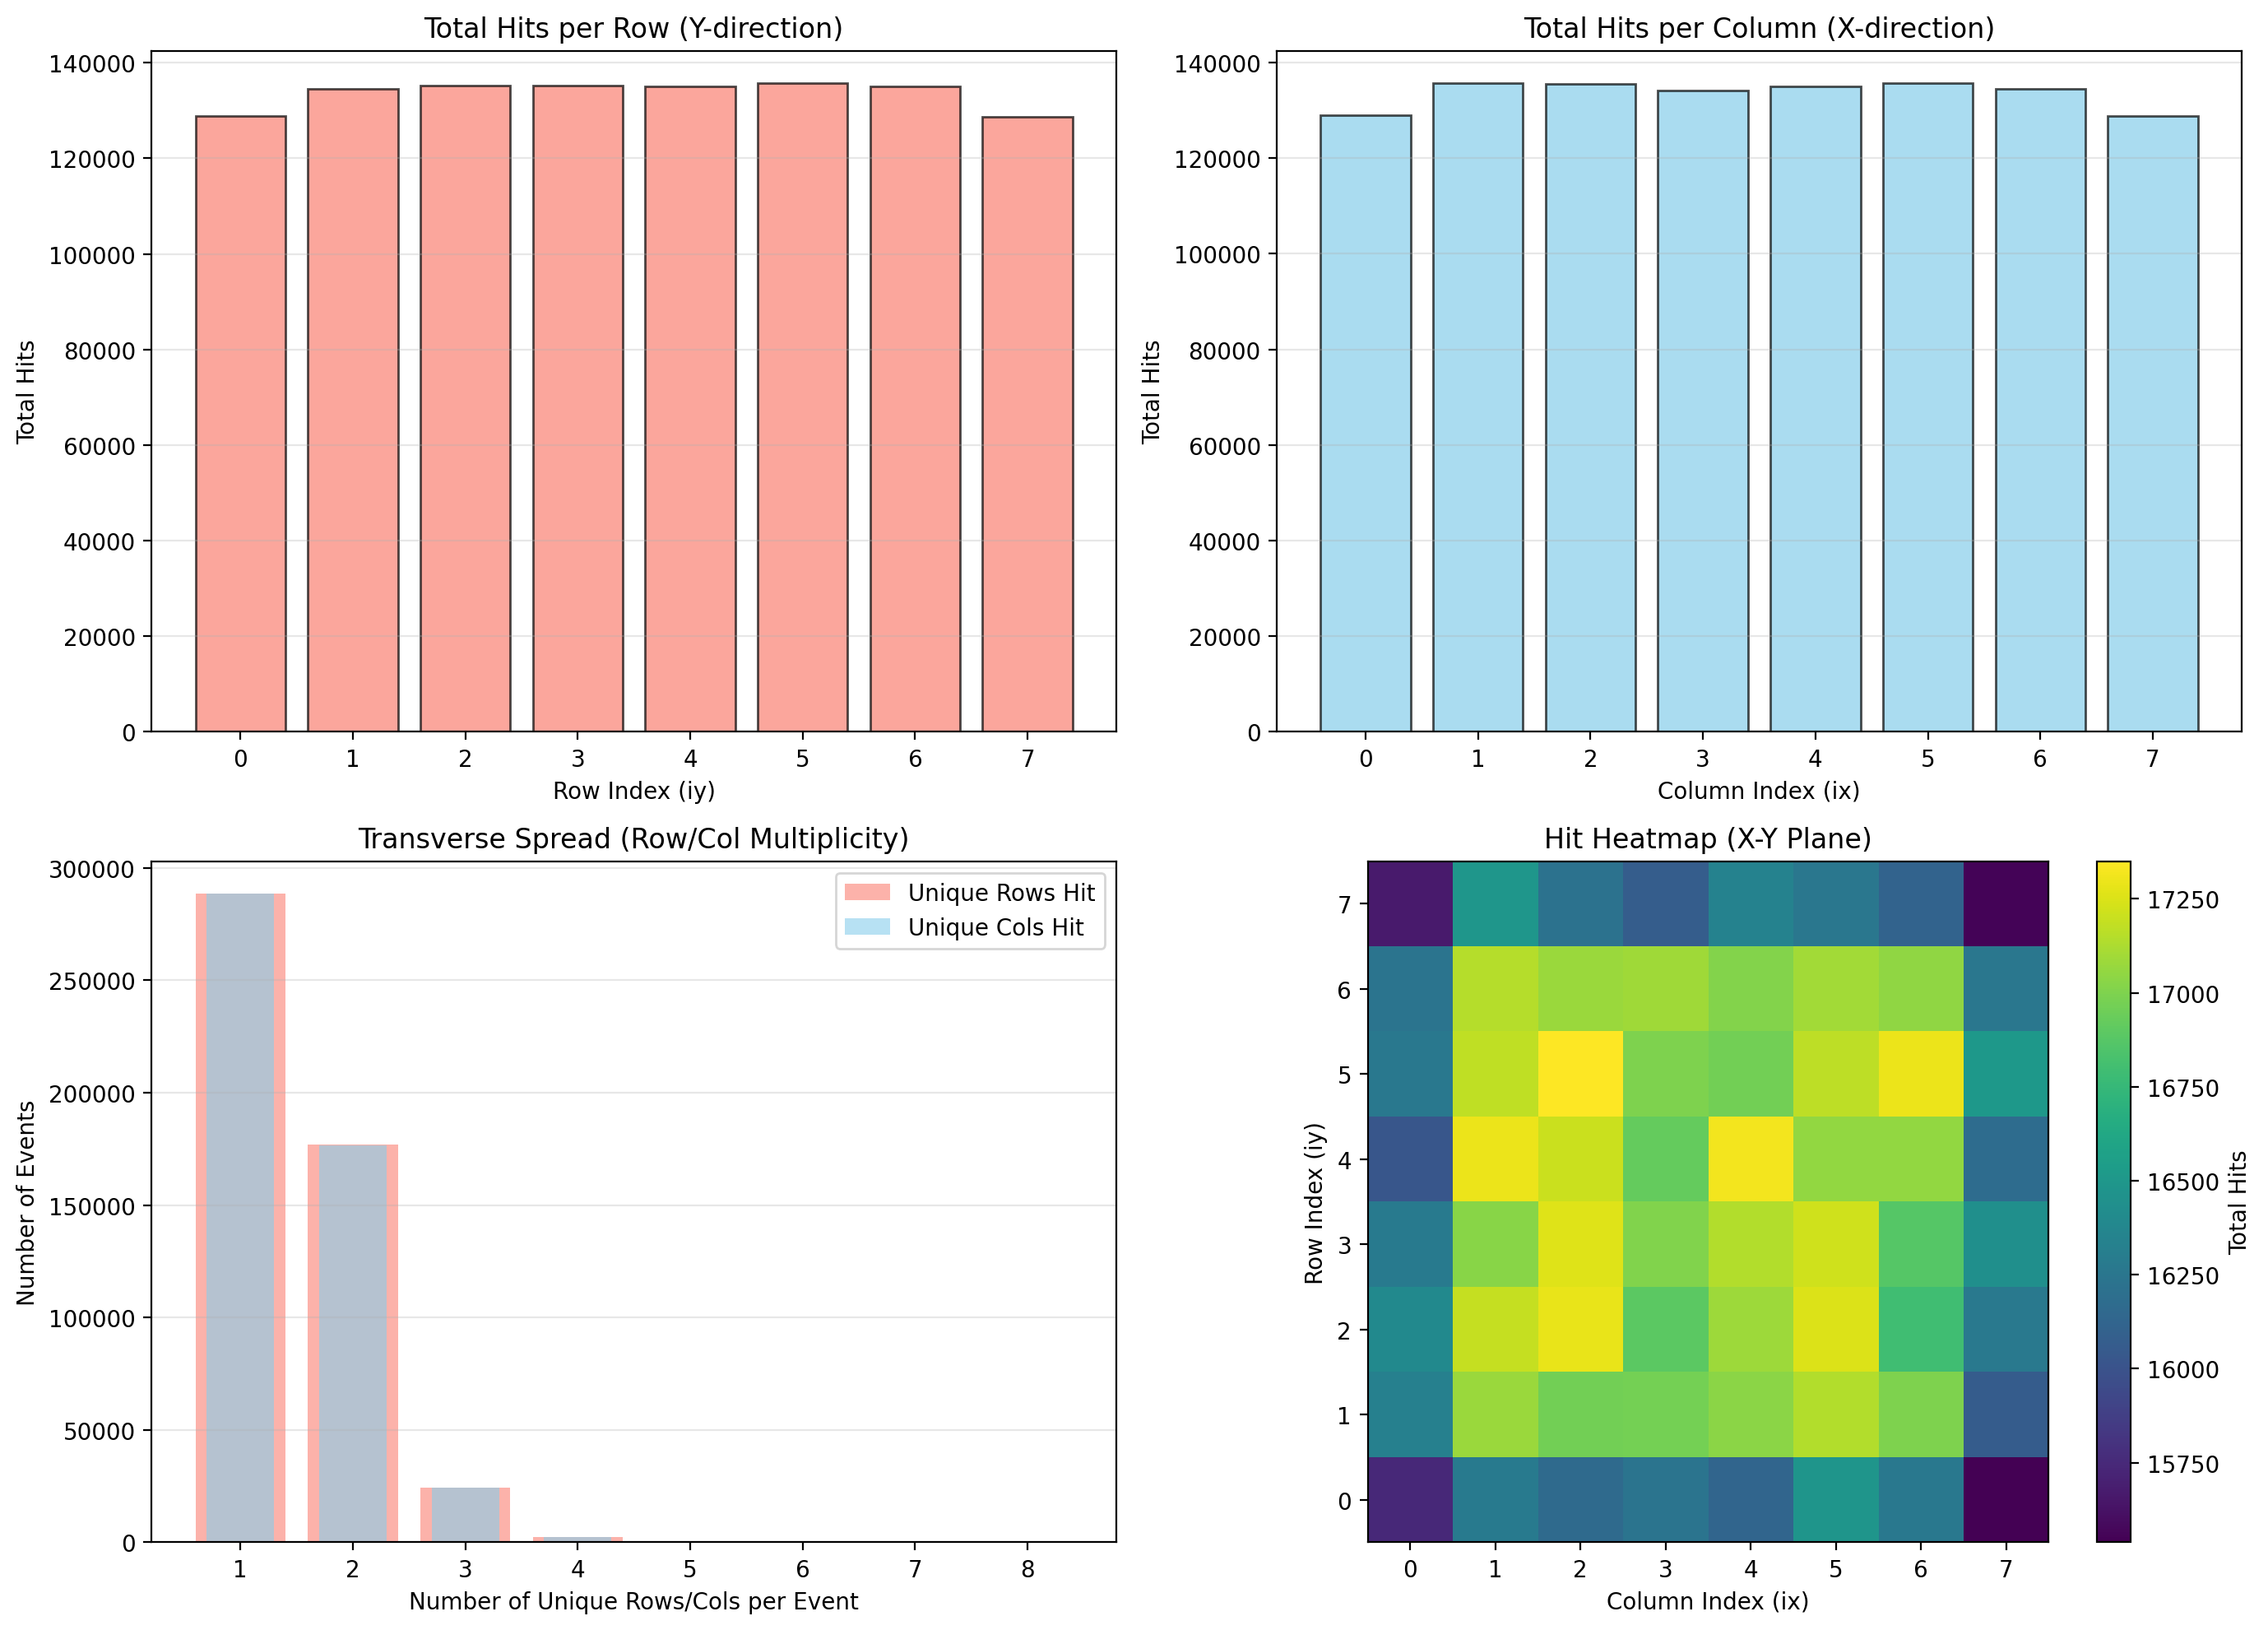

横向扩展统计:
  平均涉及行数: 1.47
  平均涉及列数: 1.47
  平均涉及层数: 1.43


In [ ]:
# 1. 解码 CrystalID 获取空间坐标索引
# 根据 DetectorConstruction.cc: ID = ix * 10000 + iy * 100 + iz
# ix: 0-7 (Column), iy: 0-7 (Row), iz: 0-4 (Layer)
df_hits["ix"] = df_hits["crystalID"] // 10000
df_hits["iy"] = (df_hits["crystalID"] % 10000) // 100
df_hits["iz"] = df_hits["crystalID"] % 100

print("坐标索引解码示例 (前5行):")
print(df_hits[["crystalID", "ix", "iy", "iz"]].head())

# 2. 统计不同行(Row/iy) 和 不同列(Column/ix) 的击中总数 (Occupancy)
# 这反映了束流的轮廓或探测器的几何接受度
row_counts = df_hits["iy"].value_counts().sort_index()
col_counts = df_hits["ix"].value_counts().sort_index()

# 3. 统计每个事件涉及的 行数 和 列数 (Spread)
# 这反映了簇射的横向扩展范围
event_spread = df_hits.groupby("EventID").agg({"ix": "nunique", "iy": "nunique", "iz": "nunique"}).rename(columns={"ix": "N_Cols", "iy": "N_Rows", "iz": "N_Layers"})

# ==========================================
# 绘图
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 图 1: 行击中分布 (Row Occupancy)
axes[0, 0].bar(row_counts.index, row_counts.values, color="salmon", alpha=0.7, edgecolor="black")
axes[0, 0].set_xlabel("Row Index (iy)")
axes[0, 0].set_ylabel("Total Hits")
axes[0, 0].set_title("Total Hits per Row (Y-direction)")
axes[0, 0].set_xticks(range(8))
axes[0, 0].grid(axis="y", alpha=0.3)

# 图 2: 列击中分布 (Column Occupancy)
axes[0, 1].bar(col_counts.index, col_counts.values, color="skyblue", alpha=0.7, edgecolor="black")
axes[0, 1].set_xlabel("Column Index (ix)")
axes[0, 1].set_ylabel("Total Hits")
axes[0, 1].set_title("Total Hits per Column (X-direction)")
axes[0, 1].set_xticks(range(8))
axes[0, 1].grid(axis="y", alpha=0.3)

# 图 3: 每个事件涉及的行数/列数分布 (Spread)
# 使用 offset 稍微错开显示
bins = np.arange(0.5, 9.5, 1)
axes[1, 0].hist(event_spread["N_Rows"], bins=bins, alpha=0.6, label="Unique Rows Hit", color="salmon", rwidth=0.8)
axes[1, 0].hist(event_spread["N_Cols"], bins=bins, alpha=0.6, label="Unique Cols Hit", color="skyblue", rwidth=0.6)
axes[1, 0].set_xlabel("Number of Unique Rows/Cols per Event")
axes[1, 0].set_ylabel("Number of Events")
axes[1, 0].set_title("Transverse Spread (Row/Col Multiplicity)")
axes[1, 0].legend()
axes[1, 0].set_xticks(range(1, 9))
axes[1, 0].grid(axis="y", alpha=0.3)

# 图 4: 2D 击中热图 (X-Y Occupancy)
# 聚合所有 Z 层的击中
xy_counts = df_hits.groupby(["ix", "iy"]).size().unstack(fill_value=0)
# 补全可能缺失的行列
for i in range(8):
    if i not in xy_counts.index:
        xy_counts.loc[i] = 0
    if i not in xy_counts.columns:
        xy_counts[i] = 0
xy_counts = xy_counts.sort_index().sort_index(axis=1)

im = axes[1, 1].imshow(xy_counts.values.T, origin="lower", cmap="viridis", interpolation="nearest")
axes[1, 1].set_xlabel("Column Index (ix)")
axes[1, 1].set_ylabel("Row Index (iy)")
axes[1, 1].set_title("Hit Heatmap (X-Y Plane)")
axes[1, 1].set_xticks(range(8))
axes[1, 1].set_yticks(range(8))
plt.colorbar(im, ax=axes[1, 1], label="Total Hits")

plt.tight_layout()
plt.show()

print("横向扩展统计:")
print(f"  平均涉及行数: {event_spread['N_Rows'].mean():.2f}")
print(f"  平均涉及列数: {event_spread['N_Cols'].mean():.2f}")
print(f"  平均涉及层数: {event_spread['N_Layers'].mean():.2f}")